> Naming update: NB multi → HBM (Hierarchical Bayesian Model)
>
> Throughout this notebook, the model previously referred to as “NB multi” is now called
> “HBM (Hierarchical Bayesian Model)”. Filenames and cached artifact paths (e.g.,
> `bayes_gene_summary_nb_multi_*`, `posterior_cache_nb_multi_*`) are kept as-is to
> preserve reproducibility and avoid breaking references. Display titles, legends, and
> narrative text refer to the model as HBM.

# HBM-CRISPR (Hierarchical Bayesian Model for CRISPR)

In [6]:
# Imports & options
import pandas as pd
import numpy as np
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Display options
pd.set_option('display.max_columns', 120)
pd.set_option('display.width', 160)

print('Libraries ready')

Libraries ready


In [7]:
# Paths
project_root = Path('..').resolve().parent  # adjust if needed
data_dir = project_root / 'data'
fig_dir = project_root / 'outputs' / 'figures'
table_dir = project_root / 'outputs' / 'tables'

sgrna_file = data_dir / 'sgrna_summary.csv'

# Ensure outputs exist
fig_dir.mkdir(parents=True, exist_ok=True)
table_dir.mkdir(parents=True, exist_ok=True)

print('Data dir  :', data_dir)
print('Figures   :', fig_dir)
print('Tables    :', table_dir)
print('sgRNA file:', sgrna_file)

Data dir  : /Users/ryodaikim/Desktop/0.projects/CRISPR-bayes/data
Figures   : /Users/ryodaikim/Desktop/0.projects/CRISPR-bayes/outputs/figures
Tables    : /Users/ryodaikim/Desktop/0.projects/CRISPR-bayes/outputs/tables
sgRNA file: /Users/ryodaikim/Desktop/0.projects/CRISPR-bayes/data/sgrna_summary.csv


In [8]:
# Load sgRNA summary (wide format)
assert sgrna_file.exists(), f'Missing file: {sgrna_file}'
sgrna_wide = pd.read_csv(sgrna_file)
print(f'Loaded sgRNA rows: {len(sgrna_wide):,}')

# Peek
display(sgrna_wide.head())

# Required columns sanity check
required_cols = {'sgrna','Gene','control_count','treatment_count'}
missing = required_cols - set(sgrna_wide.columns)
assert not missing, f'Missing required columns: {missing}'

Loaded sgRNA rows: 77,487


,sgrna,Gene,control_count,treatment_count,control_mean,treat_mean,LFC,control_var,adj_var,score,p.low,p.high,p.twosided,FDR,high_in_treatment
0,77449,FOXP3,181.16/186.77,10106/5287.9,183.96,7696.9,5.3792,15.7130,1576.90,189.19,1.0,0.0,0.0,0.0,True
1,17754,SMARCB1,81.278/78.442,4371/4091.6,79.86,4231.3,5.7099,4.0202,642.01,163.85,1.0,0.0,0.0,0.0,True
2,37463,FOXP3,102.82/143.81,7527.5/2948.8,123.32,5238.1,5.3972,840.0700,1025.00,159.76,1.0,0.0,0.0,0.0,True
3,77453,FOXP3,290.84/84.045,8696.1/3933.5,187.44,6314.8,5.0668,21381.0000,1609.10,152.75,1.0,0.0,0.0,0.0,True
4,77477,FOXP3,54.348/22.412,3420.9/1395.3,38.38,2408.1,5.9349,509.9600,291.78,138.73,1.0,0.0,0.0,0.0,True


In [9]:
# Helper to parse 'a/b' replicate fields into two floats

def _parse_two_reps(val):
    # Returns (rep1, rep2) as floats (np.nan if unavailable)
    if pd.isna(val):
        return np.nan, np.nan
    # Try string normalization
    try:
        s = str(val).strip()
    except Exception:
        return np.nan, np.nan
    parts = [p.strip() for p in s.split('/') if p.strip() != '']

    if len(parts) == 0:
        return np.nan, np.nan
    if len(parts) == 1:
        try:
            x = float(parts[0])
        except Exception:
            x = np.nan
        return x, x

    # len(parts) >= 2 → take first two entries
    try:
        a = float(parts[0])
    except Exception:
        a = np.nan
    try:
        b = float(parts[1])
    except Exception:
        b = np.nan
    return a, b

print("Helper _parse_two_reps ready")

Helper _parse_two_reps ready


In [10]:
# Parse replicate counts and attach numeric columns
ctrl_r1, ctrl_r2 = zip(*sgrna_wide['control_count'].map(_parse_two_reps))
trt_r1, trt_r2   = zip(*sgrna_wide['treatment_count'].map(_parse_two_reps))

sgrna_wide = sgrna_wide.assign(
    control_r1=pd.to_numeric(ctrl_r1, errors='coerce'),
    control_r2=pd.to_numeric(ctrl_r2, errors='coerce'),
    treatment_r1=pd.to_numeric(trt_r1, errors='coerce'),
    treatment_r2=pd.to_numeric(trt_r2, errors='coerce')
)

display(sgrna_wide[['sgrna','Gene','control_r1','control_r2','treatment_r1','treatment_r2']].head())

,sgrna,Gene,control_r1,control_r2,treatment_r1,treatment_r2
0,77449,FOXP3,181.160,186.770,10106.0,5287.9
1,17754,SMARCB1,81.278,78.442,4371.0,4091.6
2,37463,FOXP3,102.820,143.810,7527.5,2948.8
3,77453,FOXP3,290.840,84.045,8696.1,3933.5
4,77477,FOXP3,54.348,22.412,3420.9,1395.3


In [11]:
# Build tidy long-form count table (one row per sgRNA x sample)
# Assumptions:
# - treatment = FOXP3-low; control = FOXP3-high
# - Two replicates for each condition: r1, r2

rows = []
for _, row in sgrna_wide.iterrows():
    sg = row['sgrna']
    gene = row['Gene']
    # Control (FOXP3-high)
    rows.append({
        'sgrna': sg,
        'gene': gene,
        'condition': 'control',
        'replicate': 1,
        'sample_id': 'control_r1',
        'count': row.get('control_r1', np.nan)
    })
    rows.append({
        'sgrna': sg,
        'gene': gene,
        'condition': 'control',
        'replicate': 2,
        'sample_id': 'control_r2',
        'count': row.get('control_r2', np.nan)
    })
    # Treatment (FOXP3-low)
    rows.append({
        'sgrna': sg,
        'gene': gene,
        'condition': 'treatment',
        'replicate': 1,
        'sample_id': 'treatment_r1',
        'count': row.get('treatment_r1', np.nan)
    })
    rows.append({
        'sgrna': sg,
        'gene': gene,
        'condition': 'treatment',
        'replicate': 2,
        'sample_id': 'treatment_r2',
        'count': row.get('treatment_r2', np.nan)
    })

counts_long = pd.DataFrame(rows)

# Library-size normalization: per-sample size factors
lib_sizes = counts_long.groupby('sample_id')['count'].sum()
geom_mean = np.exp(np.log(lib_sizes.replace(0, np.nan)).mean())
size_factors = (lib_sizes / geom_mean).replace([np.inf, -np.inf], np.nan)
size_factors = size_factors.fillna(1.0)
size_factors = size_factors.rename('size_factor').reset_index()

# Add size factors (counts_long already has condition/replicate)
counts_long = counts_long.merge(size_factors, on='sample_id', how='left')

print('Tidy counts shape:', counts_long.shape)
print('Samples:', counts_long['sample_id'].unique())
print('NaN counts:', counts_long['count'].isna().sum())

display(counts_long.head())

Tidy counts shape: (309948, 7)
Samples: ['control_r1' 'control_r2' 'treatment_r1' 'treatment_r2']
NaN counts: 0


,sgrna,gene,condition,replicate,sample_id,count,size_factor
0,77449,FOXP3,control,1,control_r1,181.160,0.993118
1,77449,FOXP3,control,2,control_r2,186.770,0.999318
2,77449,FOXP3,treatment,1,treatment_r1,10106.000,1.002837
3,77449,FOXP3,treatment,2,treatment_r2,5287.900,1.004766
4,17754,SMARCB1,control,1,control_r1,81.278,0.993118


In [12]:
# QA/QC: Sample-level summaries
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az

plt.style.use('arviz-docgrid')

# Totals, zeros, unique sgRNAs per sample
sample_totals = counts_long.groupby('sample_id')['count'].sum().rename('total_count')
zero_counts = (
    counts_long.assign(is_zero=(counts_long['count'] == 0))
    .groupby('sample_id')['is_zero']
    .sum()
    .rename('zero_count')
)
n_sgrna = counts_long.groupby('sample_id')['sgrna'].nunique().rename('n_sgrna')

# Size factors (already merged)
sf = (
    counts_long[['sample_id','size_factor']]
    .drop_duplicates()
    .set_index('sample_id')['size_factor']
)

summary = pd.concat([sample_totals, zero_counts, n_sgrna, sf], axis=1).reset_index()
summary['nonzero'] = summary['n_sgrna'] - summary['zero_count']

print('QA/QC — sample summary:')
display(summary)


QA/QC — sample summary:


,sample_id,total_count,zero_count,n_sgrna,size_factor,nonzero
0,control_r1,2.716991e+07,8,77487,0.993118,77479
1,control_r2,2.733954e+07,14,77487,0.999318,77473
2,treatment_r1,2.743582e+07,2,77487,1.002837,77485
3,treatment_r2,2.748858e+07,7,77487,1.004766,77480


In [13]:
# Save tidy counts to outputs/tables
out_path = table_dir / 'tidy_counts.csv'
counts_long.to_csv(out_path, index=False)
print(f'Saved tidy counts to: {out_path}')

Saved tidy counts to: /Users/ryodaikim/Desktop/0.projects/CRISPR-bayes/outputs/tables/tidy_counts.csv


## Normalization: library-size factors

We use simple library-size normalization:
- For each sample, compute total sgRNA counts
- Compute the geometric mean of total counts across samples
- Define size_factor for a sample as total_count / geometric_mean
- Use log(size_factor) as an offset in GLMs and downstream models

Note: DESeq2 median-of-ratios, which is also a possible normalization method, produced size factors ≈ 1 across samples in this dataset, so it would have minimal impact.

Saved figure: /Users/ryodaikim/Desktop/0.projects/CRISPR-bayes/outputs/figures/qc_sizefactors_total_counts.png


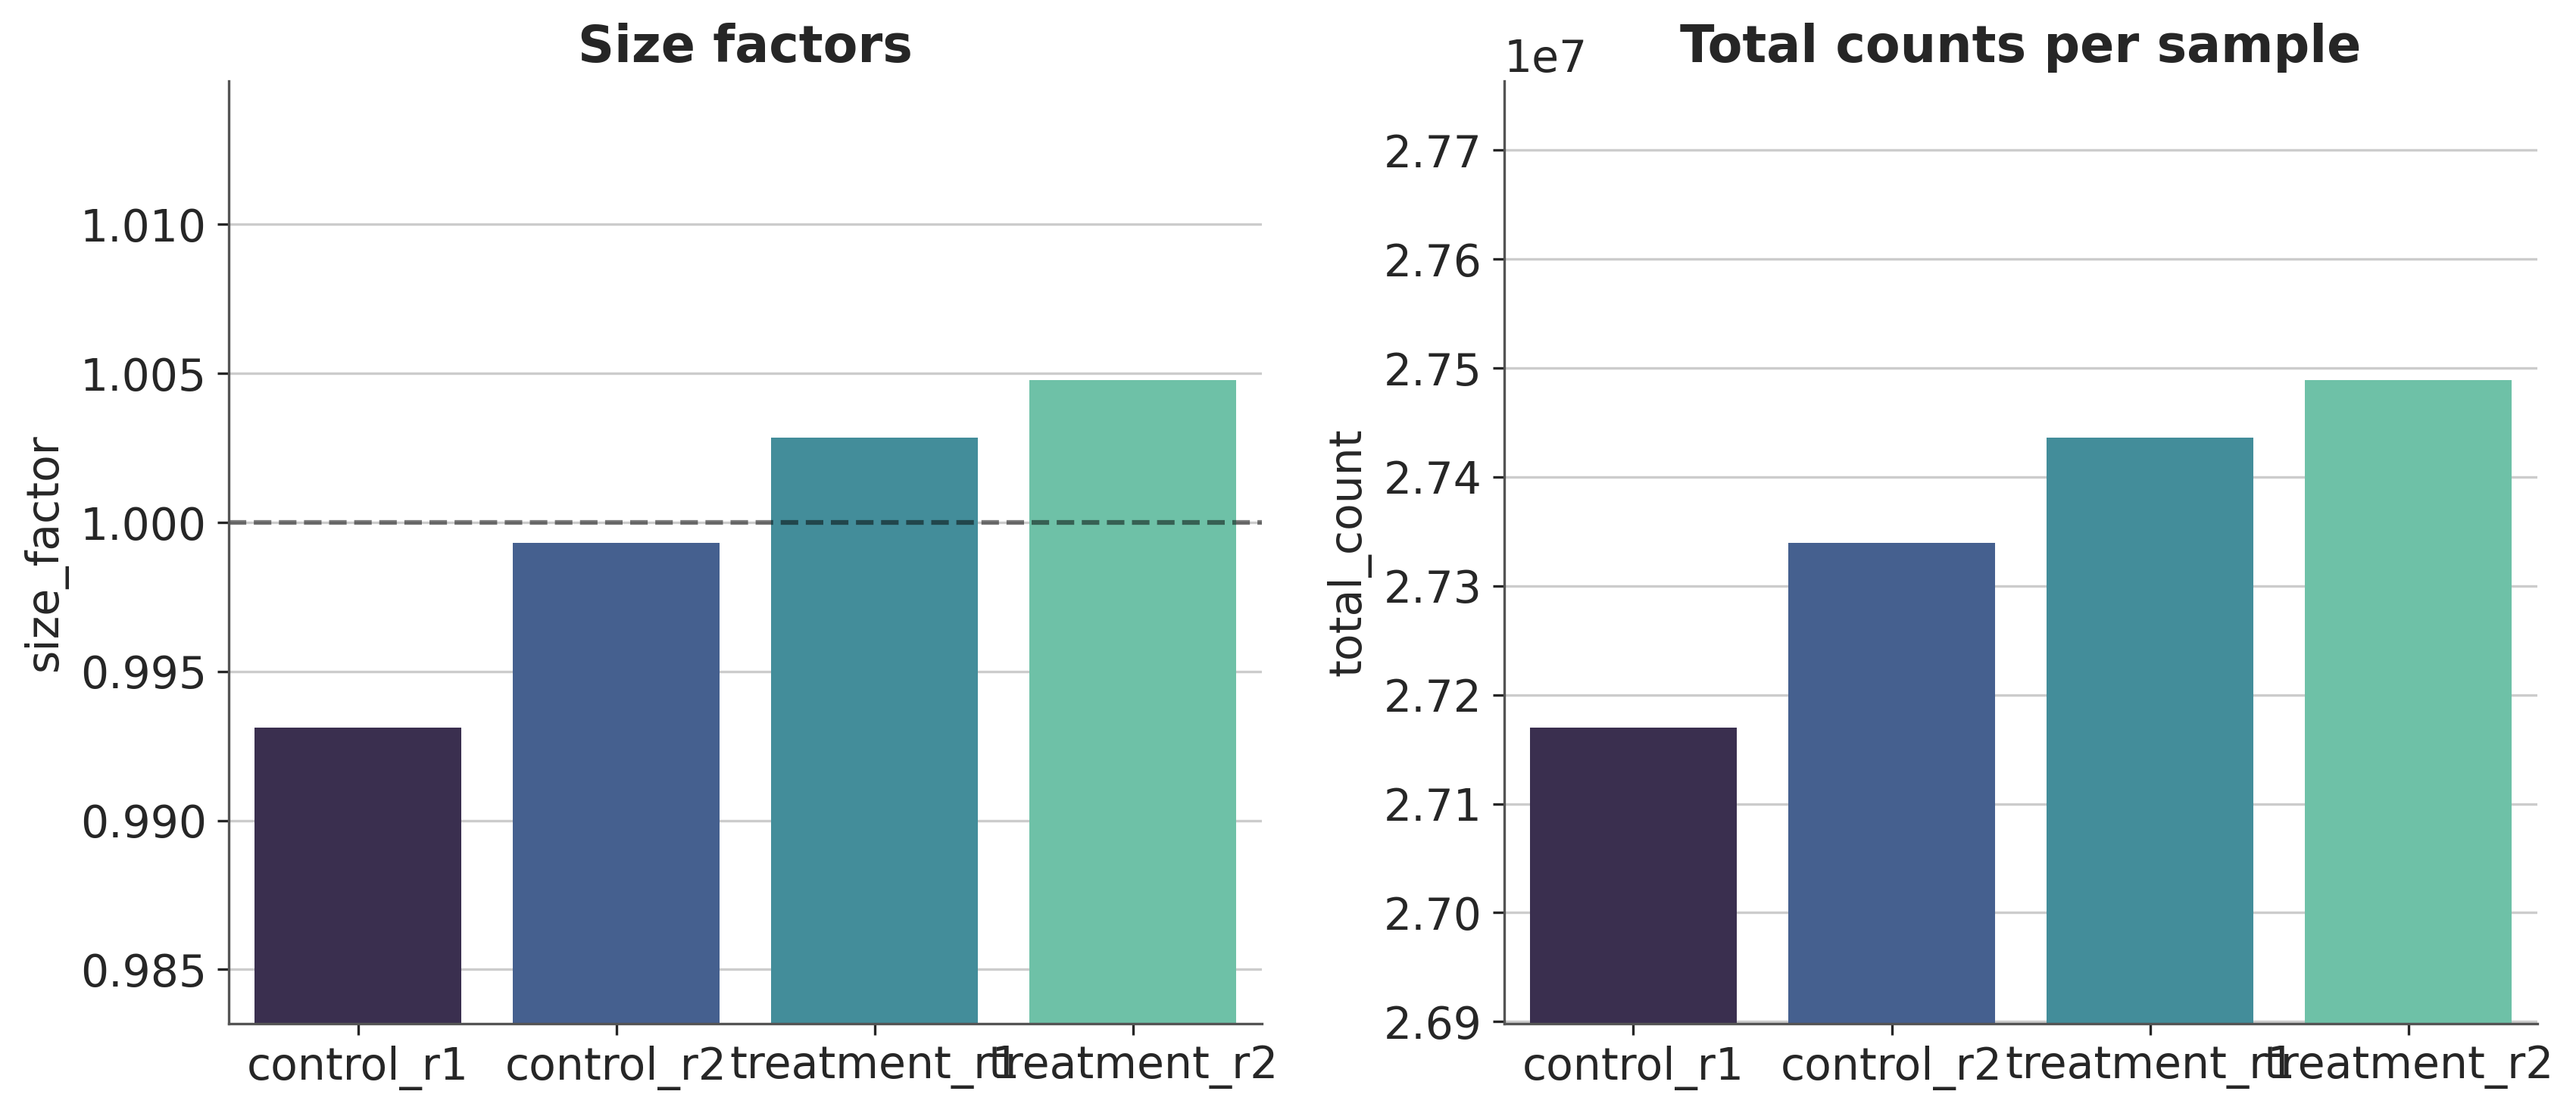

In [107]:
# QA/QC: Size factor bar plot and total counts
fig, axes = plt.subplots(1, 2)

sns.barplot(ax=axes[0], x='sample_id', y='size_factor', data=summary, palette='mako')
axes[0].set_title('Size factors')
axes[0].set_xlabel('')
axes[0].axhline(1.0, color='k', linestyle='--', alpha=0.5)
axes[0].set_ylim(summary['size_factor'].min() * .99, summary['size_factor'].max() * 1.01)

sns.barplot(ax=axes[1], x='sample_id', y='total_count', data=summary, palette='mako')
axes[1].set_title('Total counts per sample')
axes[1].set_xlabel('')
axes[1].set_ylim(summary['total_count'].min() * 0.99, summary['total_count'].max() * 1.01)

# Improve x-label readability: smaller font size and slight rotation
#for ax in axes:
#    plt.setp(ax.get_xticklabels(), rotation=25, ha='right', fontsize=8)
#    ax.tick_params(axis='x', which='major', pad=6)

plt.tight_layout()
# Save figure
fig_dir.mkdir(parents=True, exist_ok=True)
out_path_fig = fig_dir / 'qc_sizefactors_total_counts.png'
fig.savefig(str(out_path_fig), dpi=150, bbox_inches='tight')
print(f'Saved figure: {out_path_fig}')
plt.show()

Saved figure: /Users/ryodaikim/Desktop/0.projects/CRISPR-bayes/outputs/figures/qc_replicate_concordance.png


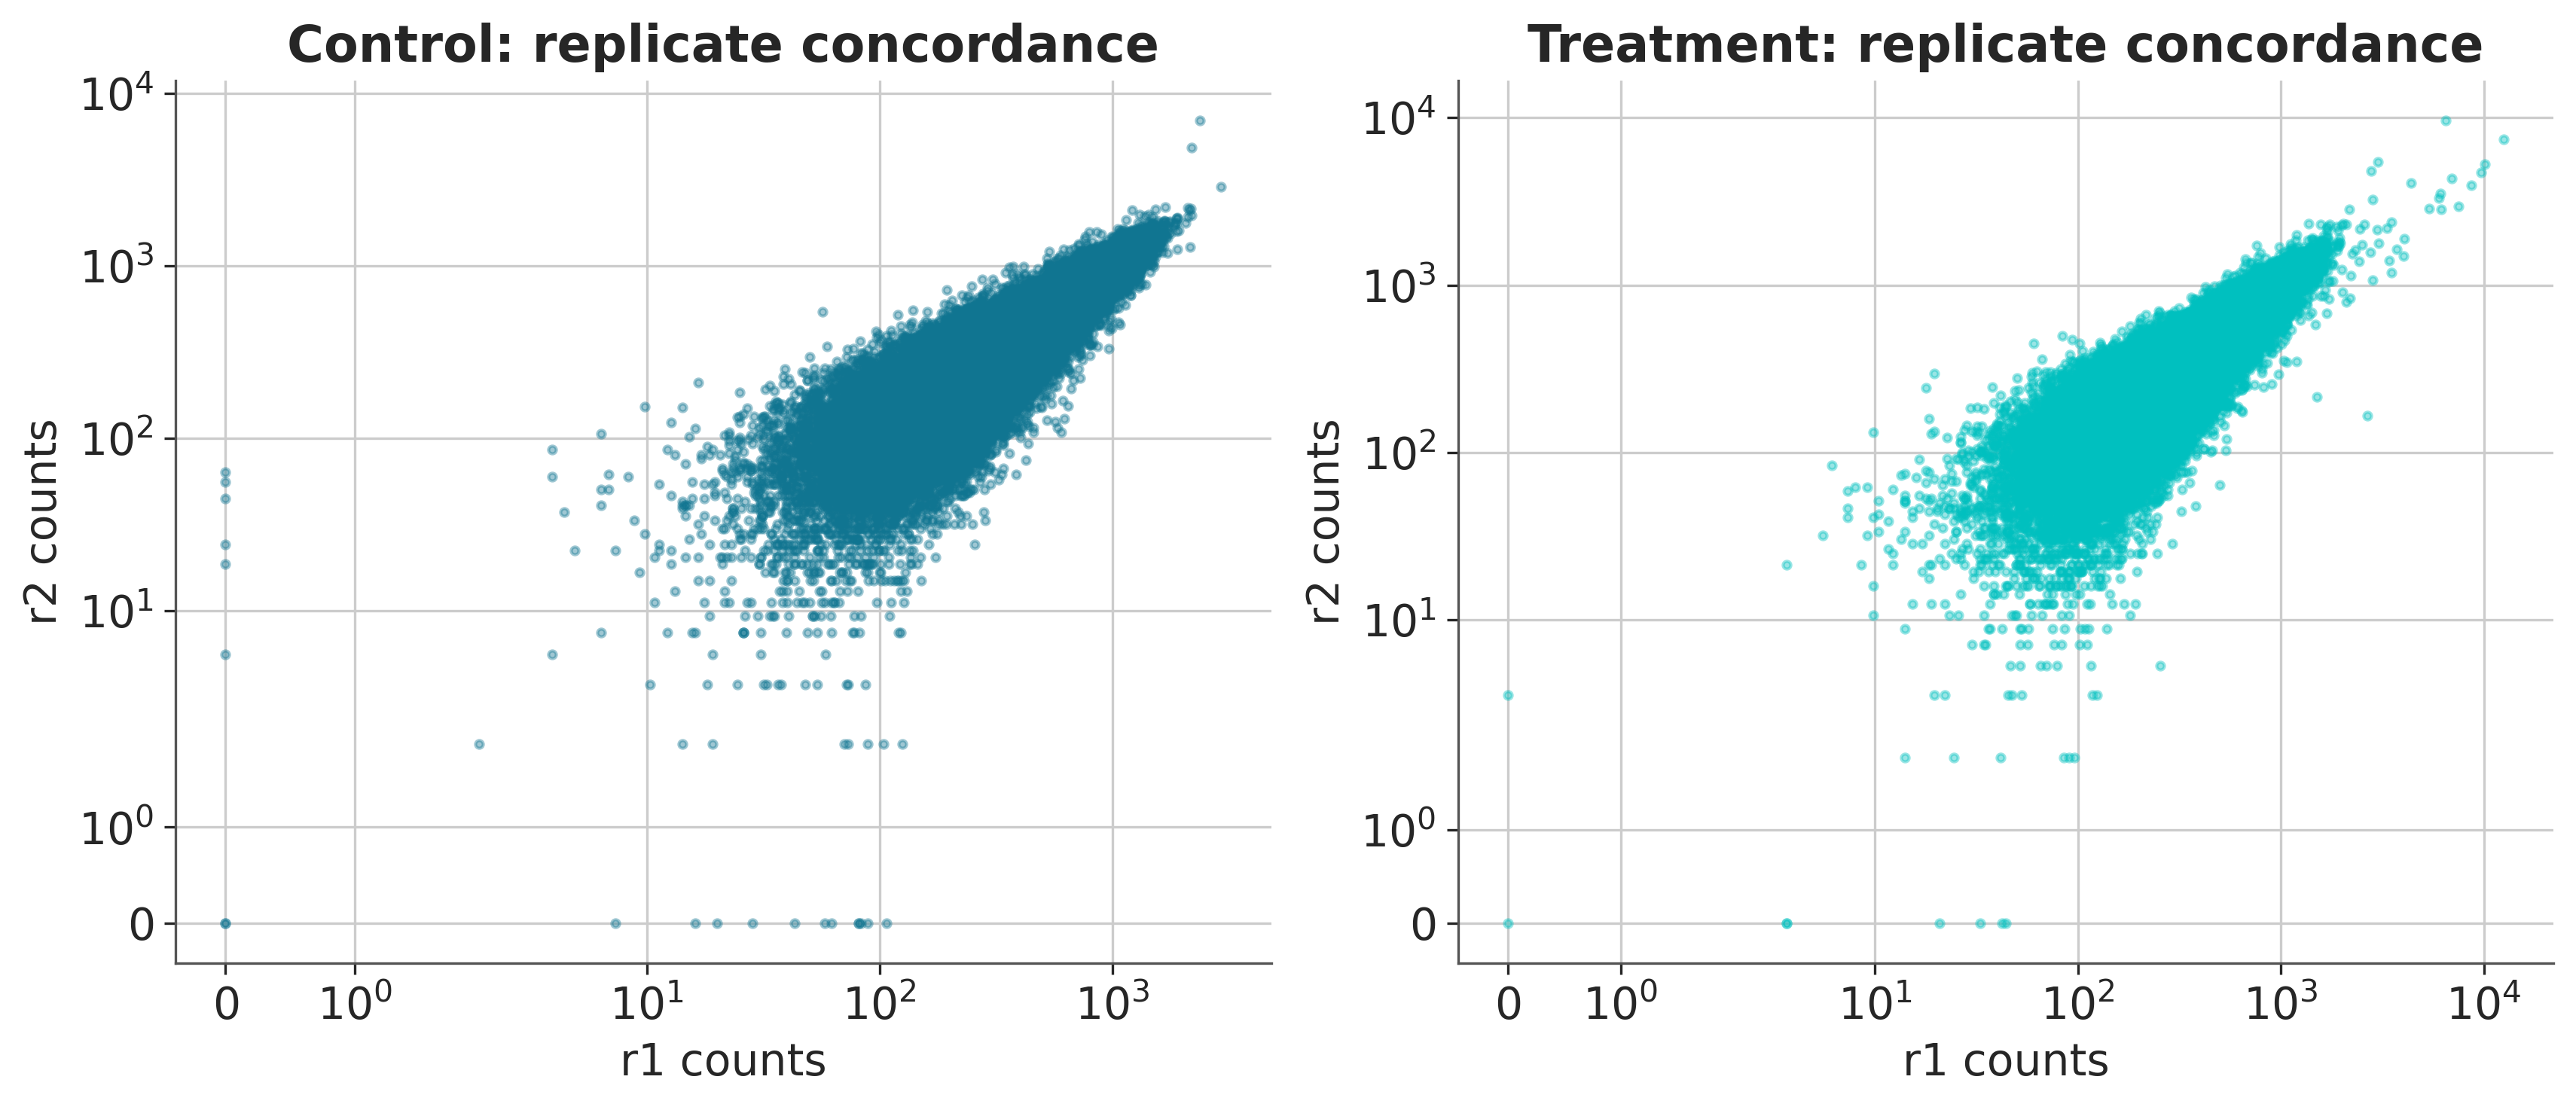

In [11]:
# QA/QC: replicate concordance (scatter) by condition
# Aggregate counts per sgRNA per replicate for each condition and plot r1 vs r2

# Control
ctrl = counts_long[counts_long['condition']=='control']
ctrl_pivot = ctrl.pivot_table(index=['sgrna','gene'], columns='replicate', values='count', aggfunc='sum')
ctrl_pivot.columns = [f'r{int(c)}' for c in ctrl_pivot.columns]

# Treatment
trt = counts_long[counts_long['condition']=='treatment']
trt_pivot = trt.pivot_table(index=['sgrna','gene'], columns='replicate', values='count', aggfunc='sum')
trt_pivot.columns = [f'r{int(c)}' for c in trt_pivot.columns]

fig, axes = plt.subplots(1, 2)

axes[0].scatter(ctrl_pivot['r1'], ctrl_pivot['r2'], s=6, alpha=0.4)
axes[0].set_xscale('symlog')
axes[0].set_yscale('symlog')
axes[0].set_title('Control: replicate concordance')
axes[0].set_xlabel('r1 counts')
axes[0].set_ylabel('r2 counts')

axes[1].scatter(trt_pivot['r1'], trt_pivot['r2'], s=6, alpha=0.4, color='C1')
axes[1].set_xscale('symlog')
axes[1].set_yscale('symlog')
axes[1].set_title('Treatment: replicate concordance')
axes[1].set_xlabel('r1 counts')
axes[1].set_ylabel('r2 counts')

plt.tight_layout()
# Save figure
fig_dir.mkdir(parents=True, exist_ok=True)
out_path_fig = fig_dir / 'qc_replicate_concordance.png'
fig.savefig(str(out_path_fig), dpi=150, bbox_inches='tight')
print(f'Saved figure: {out_path_fig}')
plt.show()

Saved figure: /Users/ryodaikim/Desktop/0.projects/CRISPR-bayes/outputs/figures/qc_ecdf_counts.png


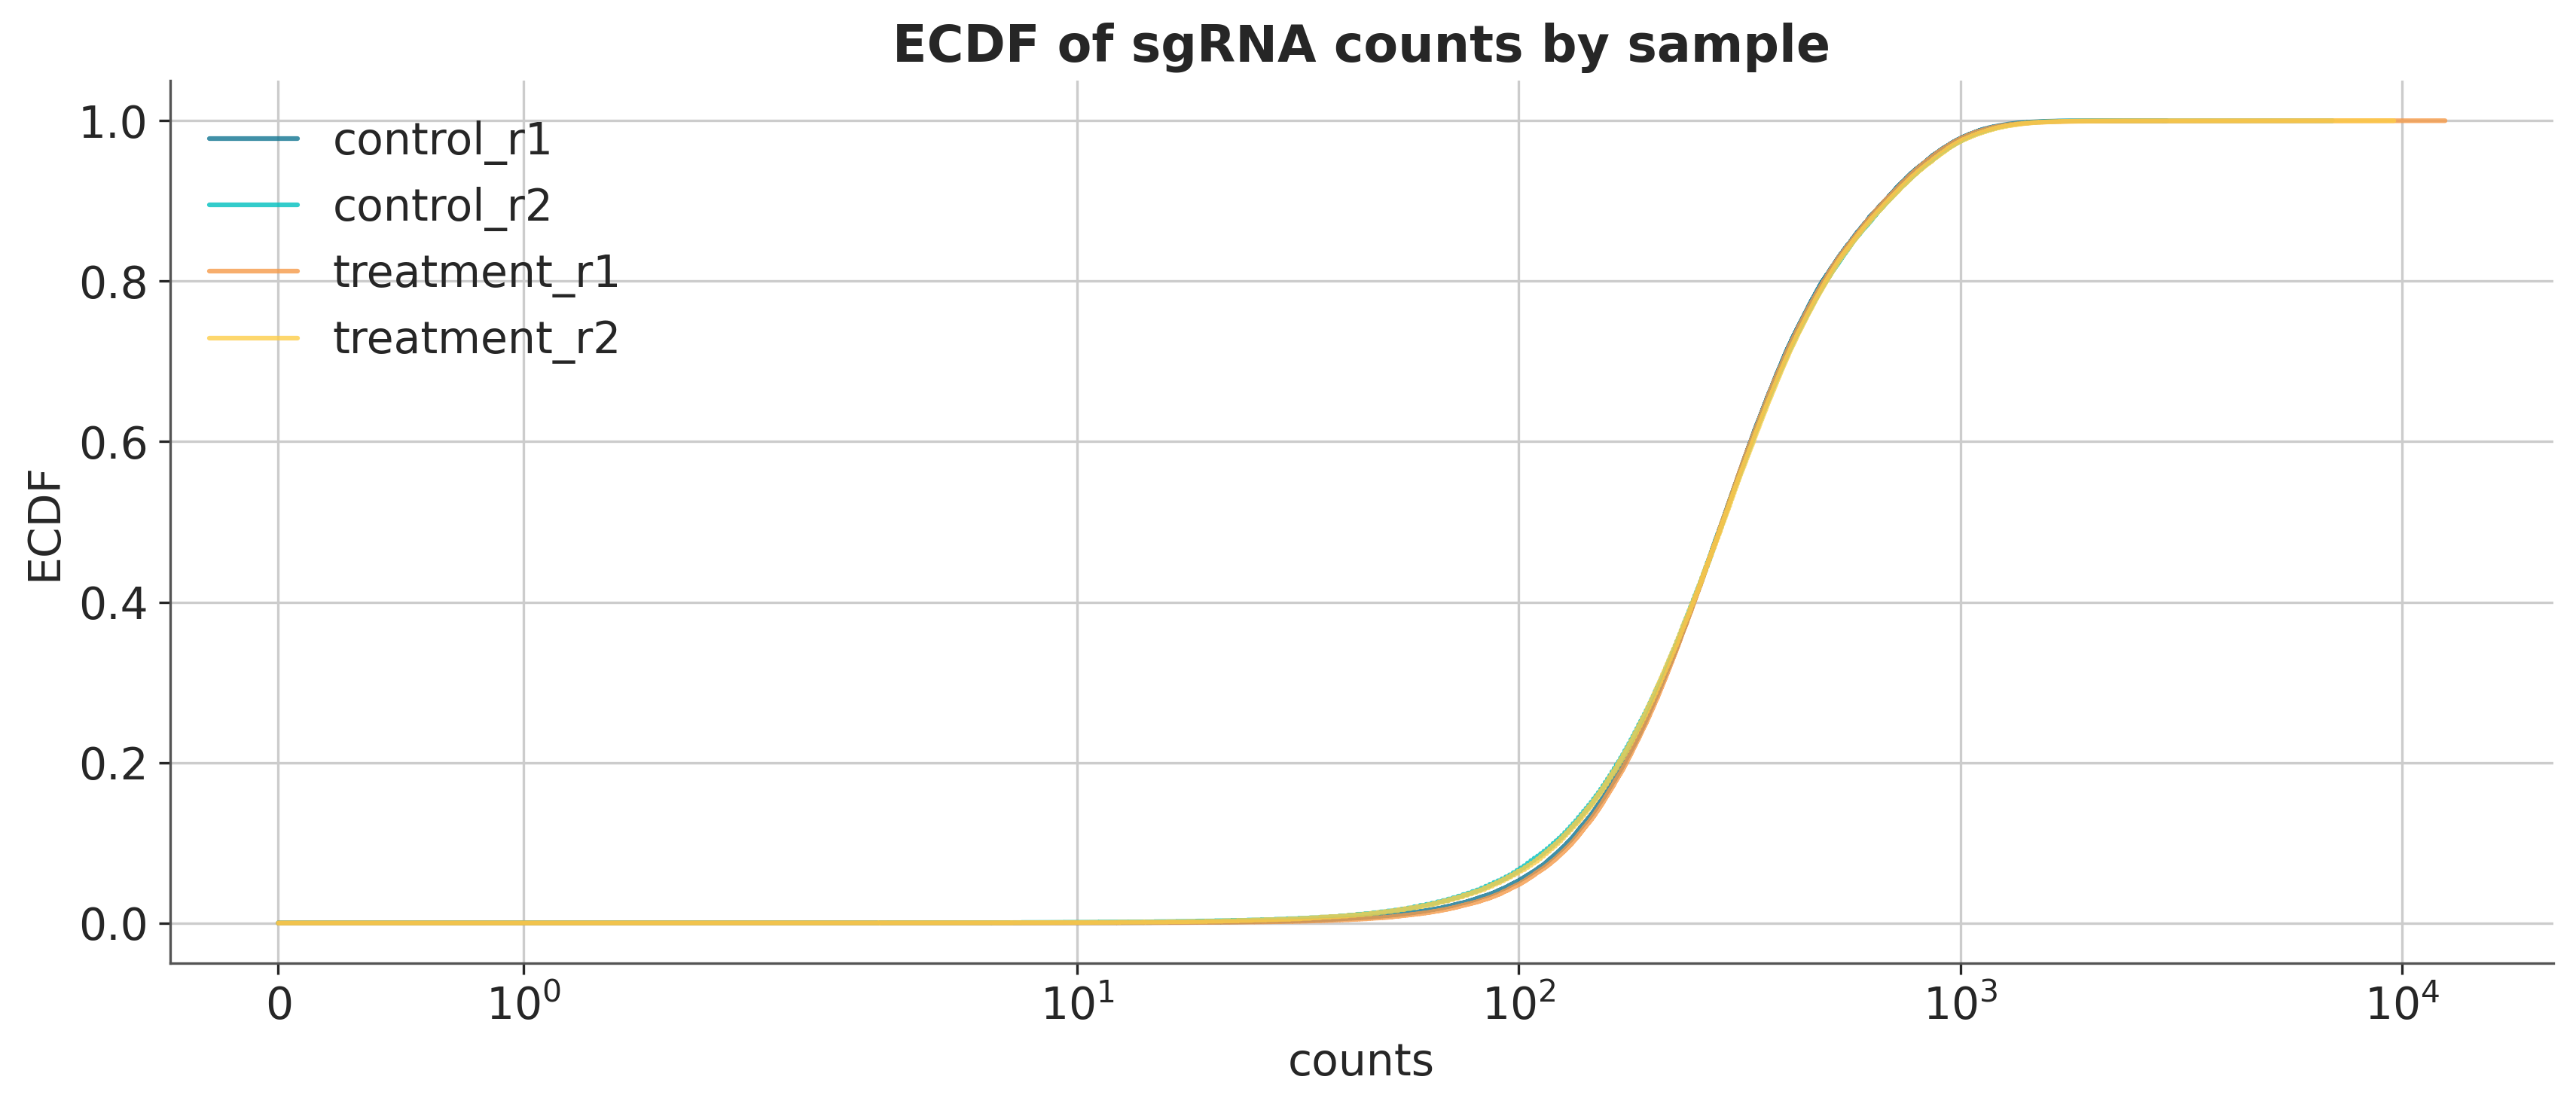

In [12]:
# QA/QC: sgRNA count distributions by sample (ECDF)
colors = {
    'control_r1': 'C0',
    'control_r2': 'C1',
    'treatment_r1': 'C2',
    'treatment_r2': 'C3',
}
for sid, grp in counts_long.groupby('sample_id'):
    x = np.sort(grp['count'].values)
    n = len(x)
    y = np.arange(1, n + 1) / n
    plt.plot(x, y, label=sid, color=colors.get(sid, None), alpha=0.8)

plt.xscale('symlog')
plt.xlabel('counts')
plt.ylabel('ECDF')
plt.title('ECDF of sgRNA counts by sample')
plt.legend()
plt.tight_layout()
# Save figure
fig_dir.mkdir(parents=True, exist_ok=True)
out_path_fig = fig_dir / 'qc_ecdf_counts.png'
plt.gcf().savefig(str(out_path_fig), dpi=150, bbox_inches='tight')
print(f'Saved figure: {out_path_fig}')
plt.show()

Saved figure: /Users/ryodaikim/Desktop/0.projects/CRISPR-bayes/outputs/figures/qc_hist_counts_by_sample.png


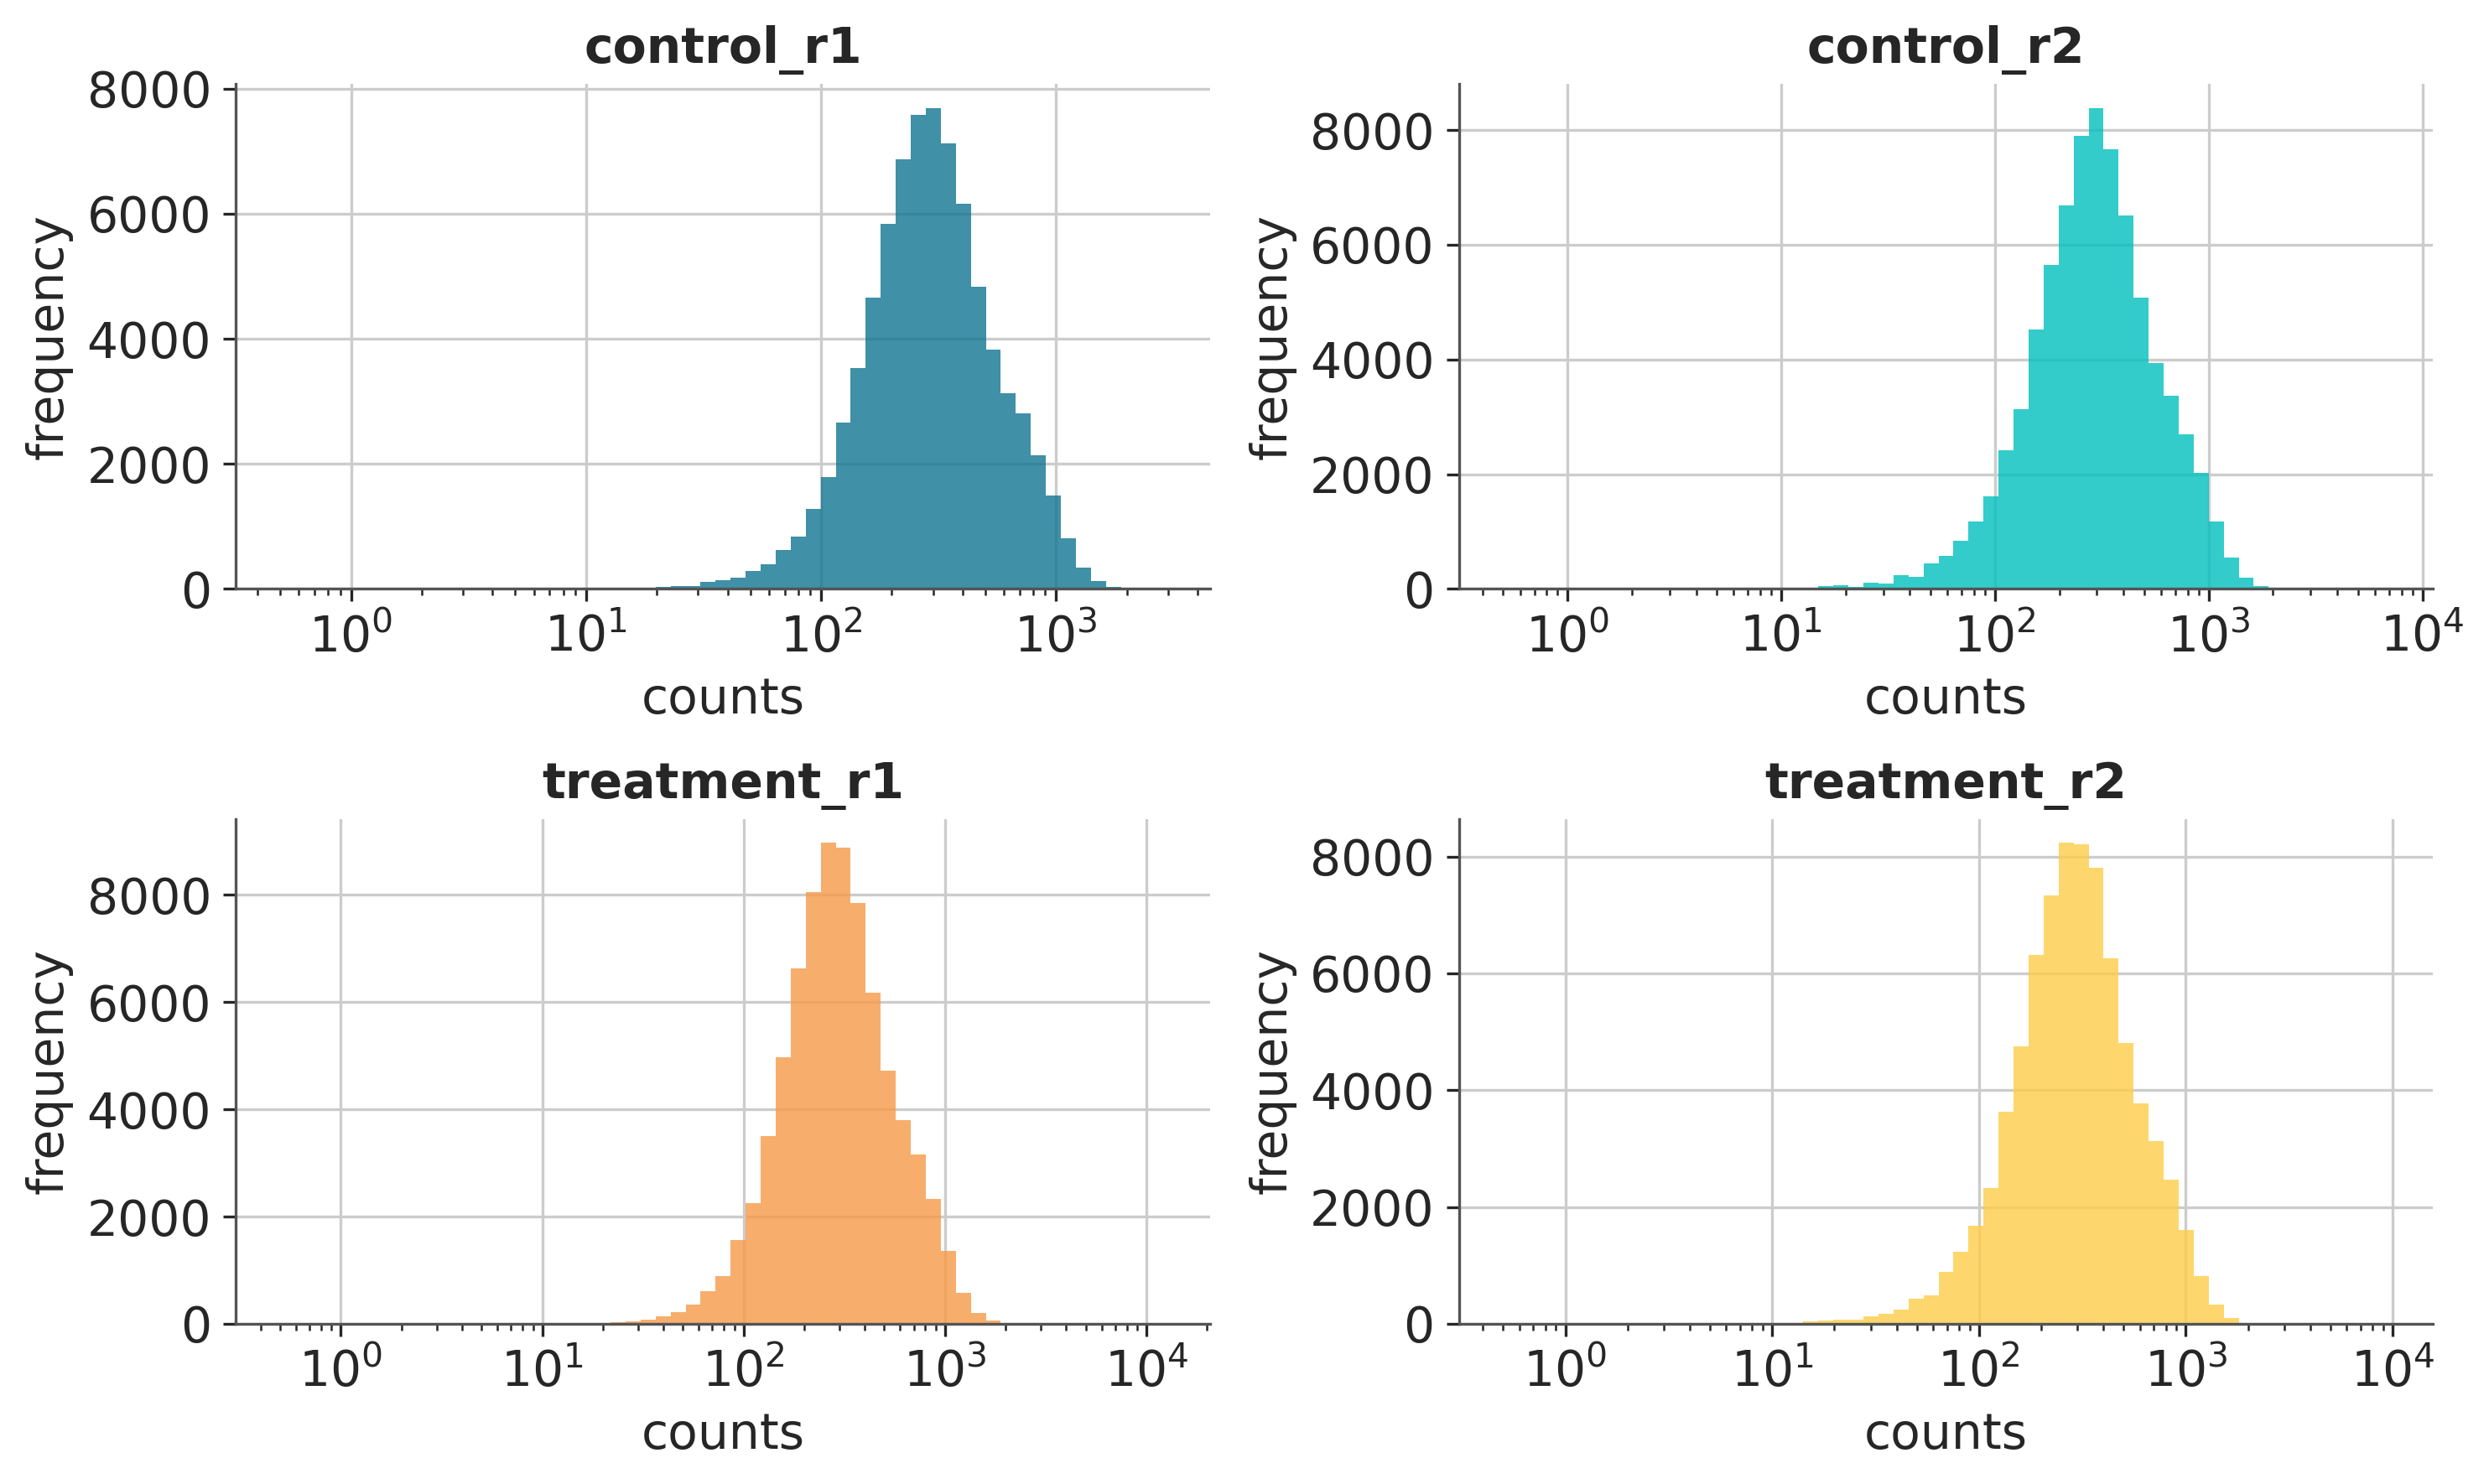

In [ ]:
# QA/QC: Per-sample histograms of sgRNA counts (log-binned)
import math

samples = summary['sample_id'].tolist()
n = len(samples)
cols = 2
rows = math.ceil(n / cols)
fig, axes = plt.subplots(rows, cols, figsize=(10, 3 * rows))
axes = axes.flatten() if n > 1 else [axes]

for i, sid in enumerate(samples):
    data = counts_long.loc[counts_long['sample_id'] == sid, 'count'].values
    # replace zeros with small positive to allow log bins
    data_plot = np.where(data <= 0, 0.5, data)
    max_val = max(1.0, data_plot.max())
    bins = np.logspace(math.log10(0.5), math.log10(max_val + 1.0), 60)
    axes[i].hist(data_plot, bins=bins, color=f'C{i}', alpha=0.8)
    axes[i].set_xscale('log')
    axes[i].set_title(sid, fontsize=14)
    axes[i].set_xlabel('counts')
    axes[i].set_ylabel('frequency')

# hide any unused subplots
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
# Save figure (single combined file)
fig_dir.mkdir(parents=True, exist_ok=True)
out_path_fig = fig_dir / 'qc_hist_counts_by_sample.png'
fig.savefig(str(out_path_fig), dpi=150, bbox_inches='tight')
print(f'Saved figure: {out_path_fig}')
plt.show()

## Benchmark: MAGeCK hit genes (FDR ≤ 0.05 and |log2FC| ≥ 0.3)

Identify hit genes from MAGeCK gene summary by combining pos/neg directions via the minimum FDR and selecting the matching log2FC. Outputs:
- `outputs/tables/bench_mageck_combined.csv`: combined FDR/log2FC per gene
- `outputs/tables/bench_mageck_hits.csv`: genes passing FDR ≤ 0.05 and |log2FC| ≥ 0.3

In [127]:
# MAGeCK benchmark: compute combined direction and hits
import pandas as pd
import numpy as np
from pathlib import Path

project_root = globals().get('project_root', Path('..').resolve().parent)
data_dir = globals().get('data_dir', project_root / 'data')
table_dir = globals().get('table_dir', project_root / 'outputs' / 'tables')

gs_path = data_dir / 'gene_summary.csv'
assert gs_path.exists(), f"Missing MAGeCK gene_summary.csv at {gs_path}"

df = pd.read_csv(gs_path)
# Expected columns in MAGeCK gene summary
req = {
    'id','neg|fdr','pos|fdr','neg|lfc','pos|lfc'
}
missing = req - set(df.columns)
if missing:
    raise ValueError(f"gene_summary.csv missing required columns: {missing}")

# Choose the direction with the smaller FDR; take its FDR and log2FC
neg_fdr = df['neg|fdr'].astype(float)
pos_fdr = df['pos|fdr'].astype(float)
neg_lfc = df['neg|lfc'].astype(float)
pos_lfc = df['pos|lfc'].astype(float)

# Combined values
best_is_neg = neg_fdr <= pos_fdr
combined_fdr = np.where(best_is_neg, neg_fdr, pos_fdr)
combined_lfc = np.where(best_is_neg, neg_lfc, pos_lfc)
combined_dir = np.where(best_is_neg, 'neg', 'pos')

out = pd.DataFrame({
    'gene': df['id'].astype(str),
    'dir': combined_dir,
    'fdr': combined_fdr,
    'log2fc': combined_lfc,
})

# Hit rule: FDR ≤ 0.05 and |log2FC| ≥ 0.3
FDR_MAX = 0.05
LFC_ABS_MIN = 0.3
out['neglog10_fdr'] = -np.log10(np.clip(out['fdr'].astype(float).values, 1e-300, 1.0))
out['abs_log2fc'] = np.abs(out['log2fc'].astype(float).values)
out['hit'] = (out['fdr'] <= FDR_MAX) & (out['abs_log2fc'] >= LFC_ABS_MIN)

# Save outputs
bench_combined = table_dir / 'bench_mageck_combined.csv'
bench_hits = table_dir / 'bench_mageck_hits.csv'
out.to_csv(bench_combined, index=False)
out.loc[out['hit']].to_csv(bench_hits, index=False)
print(f"Saved MAGeCK combined metrics: {bench_combined}")
print(f"Saved MAGeCK hits (FDR≤{FDR_MAX}, |log2FC|≥{LFC_ABS_MIN}): {bench_hits} (n={int(out['hit'].sum())})")
print(f"Number of MAGeCK hit genes: {int(out['hit'].sum())}")

# Display top 20 by FDR, tiebreak by |log2fc|
display(out.sort_values(['fdr','abs_log2fc'], ascending=[True, False]).head(20))

Saved MAGeCK combined metrics: /Users/ryodaikim/Desktop/0.projects/CRISPR-bayes/outputs/tables/bench_mageck_combined.csv
Saved MAGeCK hits (FDR≤0.05, |log2FC|≥0.3): /Users/ryodaikim/Desktop/0.projects/CRISPR-bayes/outputs/tables/bench_mageck_hits.csv (n=257)
Number of MAGeCK hit genes: 257


,gene,dir,fdr,log2fc,neglog10_fdr,abs_log2fc,hit
19110,DAD1,pos,0.000121,3.9063,3.917215,3.9063,True
19108,TGFBR1,pos,0.000121,3.6687,3.917215,3.6687,True
19111,SMARCB1,pos,0.000121,3.3875,3.917215,3.3875,True
19103,TGFBR2,pos,0.000121,3.2522,3.917215,3.2522,True
19109,SMAD3,pos,0.000121,3.0596,3.917215,3.0596,True
19112,FOXP3,pos,0.000121,3.0411,3.917215,3.0411,True
19106,USO1,pos,0.000121,2.5978,3.917215,2.5978,True
19104,SMAD4,pos,0.000121,2.5848,3.917215,2.5848,True
19107,STAT5B,pos,0.000121,2.4527,3.917215,2.4527,True
19105,RPN1,pos,0.000121,2.3858,3.917215,2.3858,True


Saved MAGeCK volcano figure: /Users/ryodaikim/Desktop/0.projects/CRISPR-bayes/outputs/figures/volcano_plot_mageck.png


<Figure size 3450x1500 with 0 Axes>

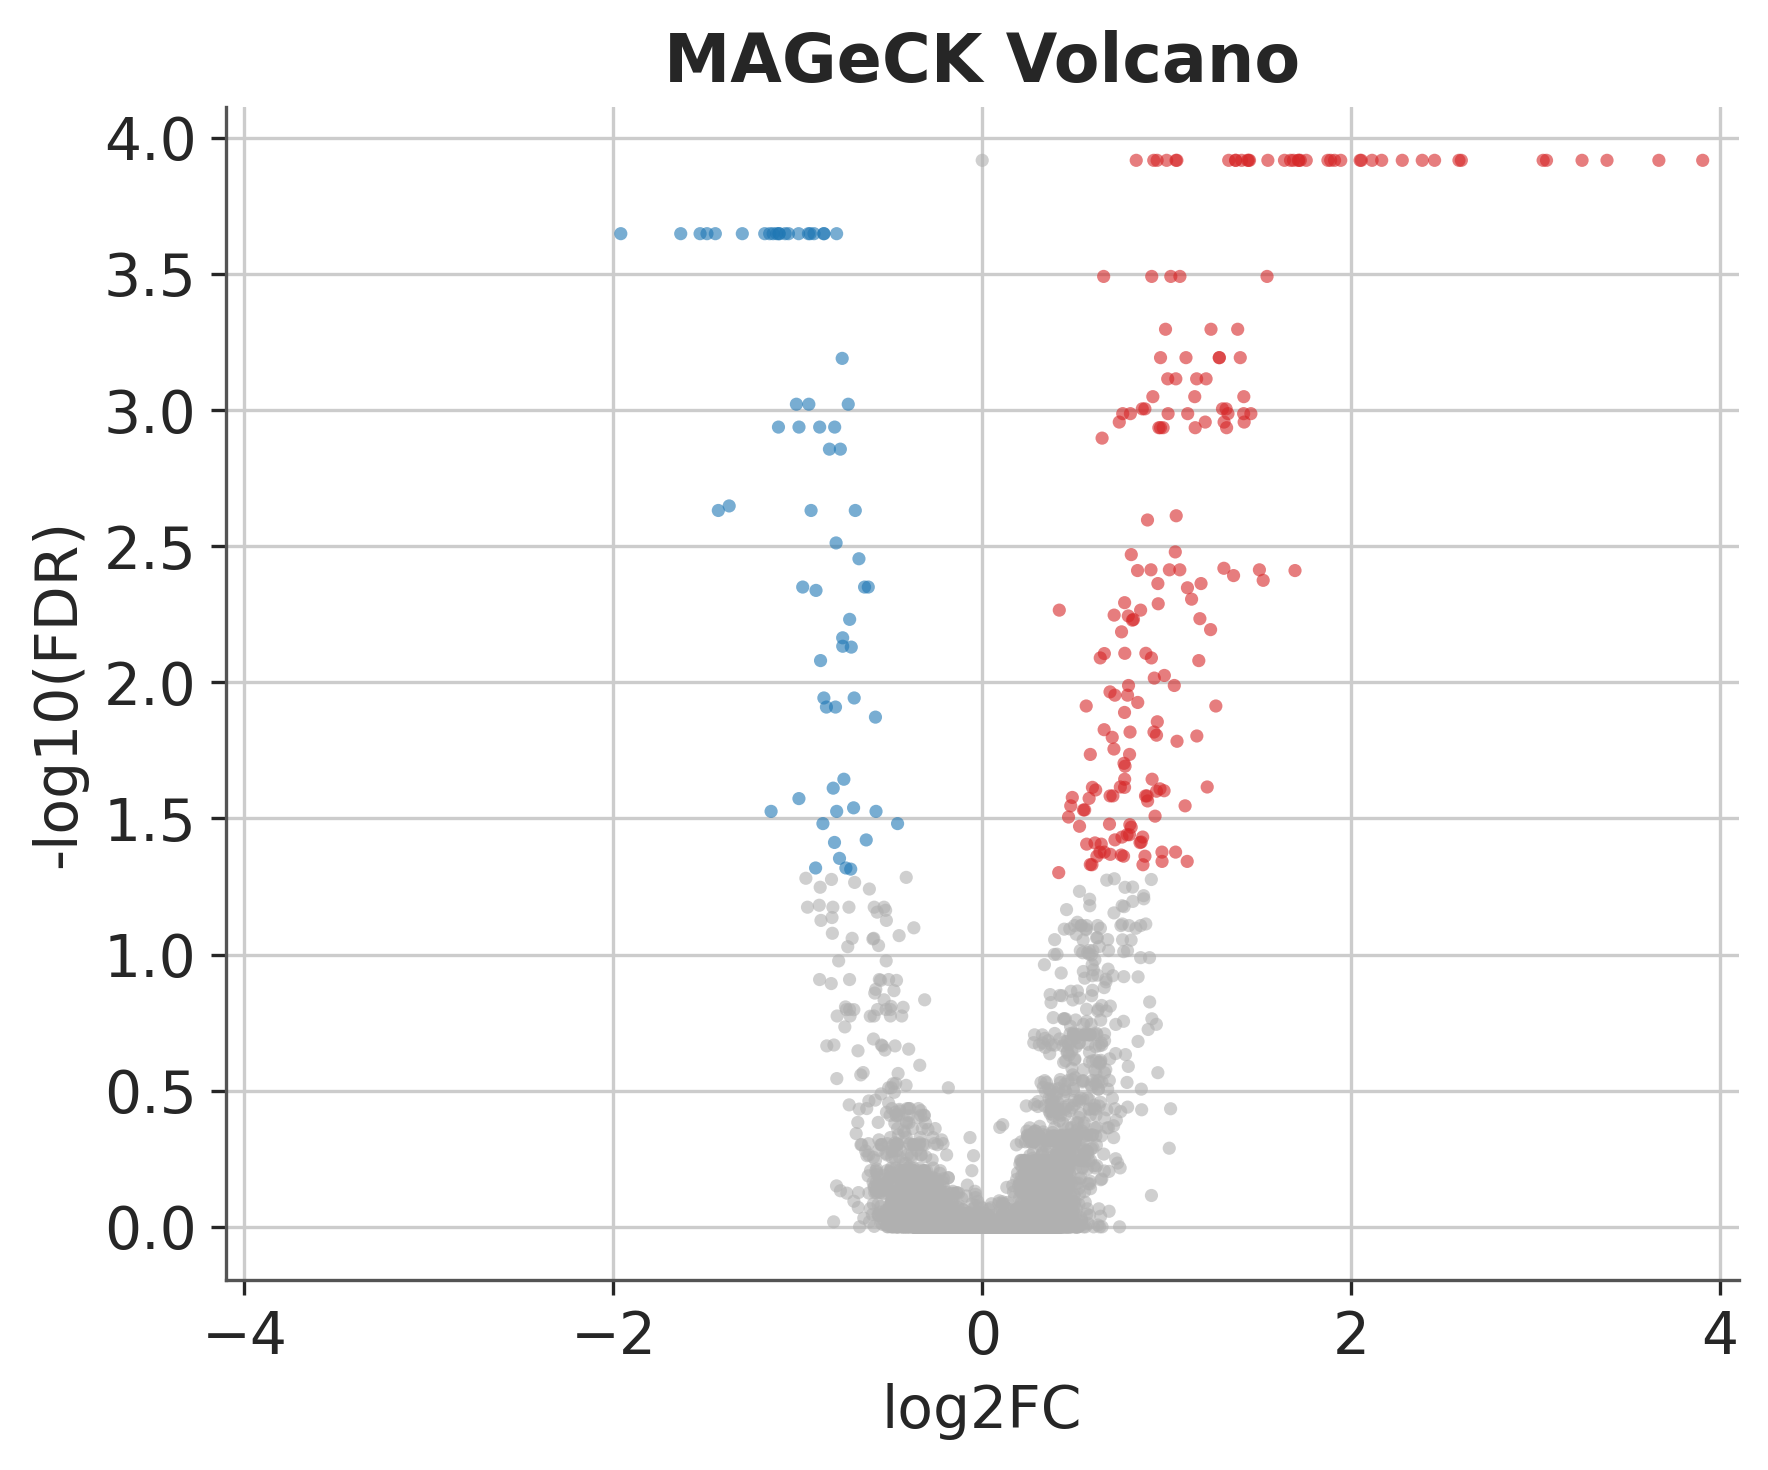

In [55]:
# Volcano plot for MAGeCK results (x=log2FC, y=-log10(FDR))
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

project_root = globals().get('project_root', Path('..').resolve().parent)
fig_dir = globals().get('fig_dir', project_root / 'outputs' / 'figures')
table_dir = globals().get('table_dir', project_root / 'outputs' / 'tables')
data_dir = globals().get('data_dir', project_root / 'data')
fig_dir.mkdir(parents=True, exist_ok=True)

# Prefer precomputed combined file; fallback to computing from MAGeCK gene_summary.csv
combined_path = table_dir / 'bench_mageck_combined.csv'
if combined_path.exists():
    df = pd.read_csv(combined_path)
else:
    gs_path = data_dir / 'gene_summary.csv'
    assert gs_path.exists(), f"Missing MAGeCK gene_summary.csv at {gs_path}"
    df_raw = pd.read_csv(gs_path)
    req = {'id','neg|fdr','pos|fdr','neg|lfc','pos|lfc'}
    missing = req - set(df_raw.columns)
    if missing:
        raise ValueError(f"gene_summary.csv missing required columns: {missing}")
    neg_fdr = df_raw['neg|fdr'].astype(float)
    pos_fdr = df_raw['pos|fdr'].astype(float)
    neg_lfc = df_raw['neg|lfc'].astype(float)
    pos_lfc = df_raw['pos|lfc'].astype(float)
    best_is_neg = neg_fdr <= pos_fdr
    combined_fdr = np.where(best_is_neg, neg_fdr, pos_fdr)
    combined_lfc = np.where(best_is_neg, neg_lfc, pos_lfc)
    df = pd.DataFrame({
        'gene': df_raw['id'].astype(str),
        'fdr': combined_fdr,
        'log2fc': combined_lfc,
    })

# Hit rule
FDR_MAX = 0.05
LFC_ABS_MIN = 0.3
EPS = 1e-300

df = df.dropna(subset=['log2fc','fdr']).copy()
df['neglog10_fdr'] = -np.log10(np.clip(df['fdr'].astype(float).values, EPS, 1.0))
df['abs_log2fc'] = np.abs(df['log2fc'].astype(float).values)
df['hit'] = (df['fdr'] <= FDR_MAX) & (df['abs_log2fc'] >= LFC_ABS_MIN)

# Colors: gray for non-hits; hits red if log2fc>0 else blue
colors = np.where(
    df['hit'].fillna(False).values,
    np.where(df['log2fc'].astype(float).values > 0, '#d62728', '#1f77b4'),
    '#b0b0b0'
)

plt.figure()
plt.figure(figsize=(6,5))
plt.scatter(df['log2fc'].astype(float), df['neglog10_fdr'].astype(float), c=colors, s=10, alpha=0.6, linewidths=0)
plt.xlabel('log2FC')
plt.ylabel('-log10(FDR)')
plt.title('MAGeCK Volcano')

# Symmetric x-limits around 0
xmax = float(np.nanmax(np.abs(df['log2fc']))) if len(df) else 1.0
if np.isfinite(xmax) and xmax > 0:
    plt.xlim(-1.05 * xmax, 1.05 * xmax)

plt.tight_layout()
out_path = fig_dir / 'volcano_plot_mageck.png'
plt.savefig(str(out_path), dpi=150, bbox_inches='tight')
print(f"Saved MAGeCK volcano figure: {out_path}")
plt.show()

## ADVI: HBM-CRISPR (Hierarchical Bayesian Model for CRISPR)

We now fit the HBM to all genes

- Objective: Jointly estimate multiple genes in a single model with global shrinkage on β_g to stabilize effect estimates.
- Likelihood (NB2):
$$
\begin{aligned}
y_{g,i,s} &\sim \mathrm{NB2}\big(\mu_{g,i,s}, \phi\big),\\
\log \mu_{g,i,s} &= \log(\text{size\_factor}_s) + \gamma_g + \beta_g\,\tilde x_s + u_{g,i} + r_s,\quad \sum_s r_s=0\\
\mathrm{Var}\!\left[y_{g,i,s}\mid \mu_{g,i,s},\phi\right] &= \mu_{g,i,s} + \frac{\mu_{g,i,s}^2}{\phi}.
\end{aligned}
$$

- Parameter/variable definitions:
  - γ_g (gene intercept): baseline log-mean count for gene g when x̃_s = 0 and the centered sample effect averages to 0; captures average abundance after library-size normalization.
  - β_g (treatment effect): per-unit change in log-mean with x̃_s. With centered coding and balanced groups (x̃_treat = +0.5, x̃_ctrl = −0.5), β_g equals the log fold-change (treatment vs control), so exp(β_g) is the rate ratio. With imbalance, the treat–control contrast is β_g·(x̄̃_treat − x̄̃_ctrl).
  - u_{g,i} (sgRNA effect): guide-level random effect for sgRNA i targeting gene g; captures guide efficiency/sequence bias and shrinks toward 0 via τ_u.
  - r_s (sample effect): sample-specific offset capturing residual multiplicative shifts (e.g., batch/replicate effects) beyond size-factor normalization; constrained so ∑_s r_s = 0 for identifiability.  

- Priors:
$$
\begin{align*}
\gamma_g &\sim \mathcal{N}(0, 1.5) \\
\beta_g &\sim \mathcal{N}(0, \tau_\beta), \quad \tau_\beta \sim \mathrm{HalfNormal}(1) \\
u_{g,i} &\sim \mathcal{N}(0, \tau_u), \quad \tau_u \sim \mathrm{HalfNormal}(1) \\
\phi &\sim \mathrm{HalfNormal}(2) \quad (\text{NB2: } \mathrm{Var}[y] = \mu + \mu^2/\phi) \\
\sum_s r_s &= 0 \quad (\text{for centered sample effects } r_s)
\end{align*}
$$
- Implemented via PyMC NegativeBinomial(mu=…, alpha=φ), which yields Var[y]=μ+μ²/φ.
- Inference: ADVI (~6,000 iters) → 1,000 variational posterior draws.
- Outputs: `outputs/tables/bayes_gene_summary_nb_multi_vi.csv`, `outputs/tables/bayes_sgrna_effects_nb_multi_vi.csv`, and posterior caches under `outputs/tables/posterior_cache_nb_multi_vi/`.

In [ ]:
# Stage-2 modeling: HBM hierarchical NB-GLM (PyMC VI) on all genes
import numpy as np
import pandas as pd
import pymc as pm
import arviz as az
from pathlib import Path
from typing import Tuple, Dict, Any

# Inputs from earlier cells
assert 'counts_long' in globals(), "counts_long not found. Run preprocessing cells first."
project_root = globals().get('project_root', Path('..').resolve().parent)
table_dir = globals().get('table_dir', project_root / 'outputs' / 'tables')
fig_dir = globals().get('fig_dir', project_root / 'outputs' / 'figures')
table_dir.mkdir(parents=True, exist_ok=True)
fig_dir.mkdir(parents=True, exist_ok=True)

# Use ALL genes (no Stage-1 screening here)
gene_list_all = counts_long['gene'].dropna().astype(str).unique().tolist()
print(f"Stage-2 HBM target genes (ALL): {len(gene_list_all):,}")

# Output files (HBM joint VI)
GENE_SUMMARY_PATH = table_dir / 'bayes_gene_summary_nb_multi_vi.csv'
SGRNA_EFFECTS_PATH = table_dir / 'bayes_sgrna_effects_nb_multi_vi.csv'

# Posterior cache for exact hit-calling
posterior_cache_dir = table_dir / 'posterior_cache_nb_multi_vi'
posterior_cache_dir.mkdir(parents=True, exist_ok=True)

# Resume capability: track already summarized genes
completed_genes = set()
if GENE_SUMMARY_PATH.exists():
    try:
        _prev = pd.read_csv(GENE_SUMMARY_PATH)
        completed_genes = set(_prev['gene'].astype(str))
        print(f"Resume: found {len(completed_genes):,} previously summarized genes.")
    except Exception:
        pass

# Also detect genes that already have cached posterior draws
cache_genes = set()
for npz_path in posterior_cache_dir.glob('beta_draws_batch_*.npz'):
    try:
        _z = np.load(npz_path, allow_pickle=True)
        _genes = [str(g) for g in _z['genes'].tolist()]
        cache_genes.update(_genes)
    except Exception:
        pass
print(f"Posterior cache coverage: {len(cache_genes):,} genes with saved draws.")

# Hyperparameters (per request)
ADVI_ITERS = 6000
POSTERIOR_DRAWS = 1000
RANDOM_SEED = 20251011

# Priors (per request)
SIGMA_GAMMA = 1.5   # for gene intercept gamma_g ~ Normal(0, 1.5)
TAU_BETA_PRIOR = 1.0  # HalfNormal(1) for tau_beta
TAU_U_PRIOR = 1.0     # HalfNormal(1) for tau_u
PHI_HN_SCALE = 2.0    # HalfNormal(2) for phi

# Batching: fit many genes at once in a single model; choose a manageable batch size for memory/perf
BATCH_SIZE = 500  # tune as needed (e.g., 100-500). Smaller if OOM.

# Helper: append df to CSV with header creation
def _append_df_csv(df: pd.DataFrame, path: Path):
    if not path.exists():
        df.to_csv(path, index=False)
    else:
        df.to_csv(path, mode='a', header=False, index=False)

# Prepare tidy data for modeling using all genes
counts_model = counts_long.copy()
counts_model['gene'] = counts_model['gene'].astype(str)
counts_model['sgrna'] = counts_model['sgrna'].astype(str)
counts_model['sample_id'] = counts_model['sample_id'].astype(str)

# Centered treatment coding per sample
sample_ref = counts_model[['sample_id','condition']].drop_duplicates()
sample_ref['treat'] = (sample_ref['condition'].astype(str) == 'treatment').astype(int)
sample_ref['x_centered'] = sample_ref['treat'] - sample_ref['treat'].mean()

# Merge x_centered into counts
counts_model = counts_model.merge(sample_ref[['sample_id','x_centered']], on='sample_id', how='left')

# Determine which genes still need posterior caches (ignore summary status)
remaining_genes = [g for g in gene_list_all if g not in cache_genes]
print(f"Genes to fit for posterior cache: {len(remaining_genes):,}")

if len(remaining_genes) == 0:
    print("Nothing to do — posterior caches already exist for all target genes.")

# Iterate over batches of genes; build one PyMC model per batch and estimate jointly
for b_start in range(0, len(remaining_genes), BATCH_SIZE):
    batch_genes = remaining_genes[b_start:b_start+BATCH_SIZE]
    batch_no = b_start // BATCH_SIZE + 1
    print(f"Batch {batch_no}: fitting {len(batch_genes)} genes …")
    df_b = counts_model[counts_model['gene'].isin(batch_genes)].copy()

    # Build indices
    gene_codes = pd.Categorical(df_b['gene'].astype(str))
    G = len(gene_codes.categories)
    gene_idx = gene_codes.codes.astype('int64')

    # sgRNA nested within genes: build a unique index per sgRNA across batch
    # We'll keep a mapping to (gene, sgRNA) for outputs
    sg_pair = df_b['gene'].astype(str) + '||' + df_b['sgrna'].astype(str)
    sg_codes = pd.Categorical(sg_pair)
    S = len(sg_codes.categories)
    sg_idx = sg_codes.codes.astype('int64')

    # sample index and x_centered
    smp_codes = pd.Categorical(df_b['sample_id'].astype(str))
    R = len(smp_codes.categories)
    smp_idx = smp_codes.codes.astype('int64')

    x = df_b['x_centered'].astype(float).values
    offset = np.log(df_b['size_factor'].astype(float).values + 1e-12)
    y = df_b['count'].astype('int64').values

    with pm.Model() as model:
        # Gene-level intercepts gamma_g with Normal(0, 1.5)
        sigma_gamma = SIGMA_GAMMA
        gamma_g = pm.Normal('gamma_g', mu=0.0, sigma=sigma_gamma, shape=G)

        # Global shrinkage for beta_g via tau_beta ~ HalfNormal(1)
        tau_beta = pm.HalfNormal('tau_beta', sigma=TAU_BETA_PRIOR)
        beta_g = pm.Normal('beta_g', mu=0.0, sigma=tau_beta, shape=G)

        # sgRNA random effects across all sgRNAs with tau_u ~ HalfNormal(1)
        tau_u = pm.HalfNormal('tau_u', sigma=TAU_U_PRIOR)
        u_sg = pm.Normal('u_sg', mu=0.0, sigma=tau_u, shape=S)

        # Sample effects with sum-to-zero via centering
        r_raw = pm.Normal('r_raw', mu=0.0, sigma=0.5, shape=R)
        r = pm.Deterministic('r', r_raw - pm.math.mean(r_raw))

        # Overdispersion shared across batch: phi ~ HalfNormal(2)
        phi = pm.HalfNormal('phi', sigma=PHI_HN_SCALE)

        # Linear predictor and mean
        eta = offset + gamma_g[gene_idx] + beta_g[gene_idx] * x + u_sg[sg_idx] + r[smp_idx]
        mu = pm.Deterministic('mu', pm.math.exp(eta))

        # Likelihood NB2 parameterization (mu, alpha=phi)
        pm.NegativeBinomial('y', mu=mu, alpha=phi, observed=y)

        # Variational inference
        approx = pm.fit(n=ADVI_ITERS, method='advi')
        idata = approx.sample(draws=POSTERIOR_DRAWS, random_seed=RANDOM_SEED)

    # Summaries per gene and per sgRNA
    post = idata.posterior
    beta_draws = np.asarray(post['beta_g'])  # dims: chain, draw, G
    beta_flat = beta_draws.reshape(-1, beta_draws.shape[-1])  # draws x G
    gamma_draws = np.asarray(post['gamma_g'])
    tau_beta_draws = np.asarray(post['tau_beta']).reshape(-1)
    tau_u_draws = np.asarray(post['tau_u']).reshape(-1)
    phi_draws = np.asarray(post['phi']).reshape(-1)

    # Save posterior beta draws for exact hit-calling
    cache_path = posterior_cache_dir / f"beta_draws_batch_{batch_no:03d}.npz"
    try:
        np.savez_compressed(
            cache_path,
            beta=beta_flat.astype(np.float32),
            genes=np.array(list(gene_codes.categories.astype(str)), dtype='U'),
        )
        print(f"Saved beta draws cache: {cache_path}")
    except Exception as e:
        print(f"Warning: failed to save posterior cache {cache_path}: {e}")

    # Compute PSP/lfsr for each gene
    psp = (beta_flat > 0).mean(axis=0)
    lfsr = np.minimum(psp, 1 - psp)
    beta_mean = beta_flat.mean(axis=0)
    beta_sd = beta_flat.std(axis=0, ddof=1)

    # Map category codes back to gene names
    genes_in_batch = list(gene_codes.categories.astype(str))

    gene_rows = []
    for j, gname in enumerate(genes_in_batch):
        n_obs_g = int((gene_idx == j).sum())
        n_sg_g = int(df_b.loc[df_b['gene'].astype(str) == gname, 'sgrna'].nunique())
        n_smp_g = R  # same sample set across genes in batch
        gene_rows.append({
            'gene': gname,
            'beta_mean': float(beta_mean[j]),
            'beta_sd': float(beta_sd[j]),
            'psp': float(psp[j]),
            'lfsr': float(lfsr[j]),
            'tau_beta_mean': float(tau_beta_draws.mean()),
            'tau_u_mean': float(tau_u_draws.mean()),
            'phi_mean': float(phi_draws.mean()),
            'n_obs': n_obs_g,
            'n_sgrna': n_sg_g,
            'n_sample': n_smp_g,
            'batch_size': G
        })

    # Append gene summary, avoiding duplicates for already summarized genes
    if len(gene_rows):
        df_rows = pd.DataFrame(gene_rows)
        to_write = df_rows[~df_rows['gene'].astype(str).isin(completed_genes)] if len(completed_genes) else df_rows
        if len(to_write):
            _append_df_csv(to_write, GENE_SUMMARY_PATH)

    # sgRNA-level summaries: posterior mean of u_sg for each (gene, sgRNA) pair
    u_draws = np.asarray(post['u_sg'])  # chain, draw, S
    u_mean = u_draws.mean(axis=(0, 1))
    # Decode sg category back to (gene, sgRNA)
    sg_map = pd.Series(list(sg_codes.categories.astype(str)), name='pair')
    gene_name_from_pair = sg_map.str.split('||', n=1, expand=True)[0]
    sgrna_from_pair = sg_map.str.split('||', n=1, expand=True)[1]

    sg_out = pd.DataFrame({
        'gene': gene_name_from_pair,
        'sgrna': sgrna_from_pair,
        'u_mean': u_mean
    })
    _append_df_csv(sg_out, SGRNA_EFFECTS_PATH)

    print(f"Saved batch {batch_no}: genes {len(gene_rows)} → {GENE_SUMMARY_PATH}")

print("HBM modeling complete (with posterior caches).")

In [ ]:
# Hit calling for HBM results (using exact posterior draws)
import pandas as pd
import numpy as np
from pathlib import Path

# IO paths
project_root = globals().get('project_root', Path('..').resolve().parent)
table_dir = globals().get('table_dir', project_root / 'outputs' / 'tables')
summary_path = table_dir / 'bayes_gene_summary_nb_multi_vi.csv'
posterior_cache_dir = table_dir / 'posterior_cache_nb_multi_vi'

assert summary_path.exists(), f"Missing: {summary_path}. Run HBM first."
assert posterior_cache_dir.exists(), f"Missing posterior cache dir: {posterior_cache_dir}. Re-run modeling cell to save caches."

# Load summary
gsum = pd.read_csv(summary_path)
if 'gene' not in gsum.columns:
    raise ValueError('Summary must include gene column')

genes = gsum['gene'].astype(str).tolist()

# Decision thresholds
LFSR_MAX = 0.1
BETA_ABS_THRESH = 0.3  # main absolute effect threshold for hit calling
ALT_ABS_THRESH = 0.5   # optional compatibility column for older plots
PROB_MIN = 0.8

# Gather exact posterior draws from caches
beta_draws_map = {}  # gene -> 1D array of draws
cache_files = sorted(posterior_cache_dir.glob('beta_draws_batch_*.npz'))
for npz_path in cache_files:
    try:
        z = np.load(npz_path, allow_pickle=True)
        if 'beta' not in z or 'genes' not in z:
            print(f"Warning: cache missing expected arrays: {npz_path}")
            continue
        beta = z['beta']  # shape: draws x G_batch
        genes_batch = [str(g) for g in np.array(z['genes']).tolist()]
        if beta.shape[-1] != len(genes_batch):
            print(f"Warning: beta shape {beta.shape} mismatches genes ({len(genes_batch)}) in {npz_path}")
        for j, g in enumerate(genes_batch):
            if j < beta.shape[-1]:
                beta_draws_map[g] = beta[:, j]
    except Exception as e:
        print(f"Warning: failed to read cache {npz_path}: {e}")

if not beta_draws_map:
    raise RuntimeError("No posterior draws found. Re-run the modeling cell to generate caches.")

# Overlap diagnostics
genes_set = set(genes)
cache_set = set(beta_draws_map.keys())
common_genes = sorted(genes_set & cache_set)
print(f"Genes in summary: {len(genes_set):,}; with draws: {len(cache_set):,}; overlap: {len(common_genes):,}")

# Compute probabilities from draws
p_abs_main = []   # P(|beta| >= 0.3) by default
p_abs_alt = []    # P(|beta| >= 0.5) for compatibility
p_pos = []
p_neg = []
psp_draws = []    # P(beta>0)
lfsr_draws = []   # min(psp, 1-psp)

for g in genes:
    draws = beta_draws_map.get(g)
    if draws is None or len(draws) == 0:
        p_abs_main.append(np.nan)
        p_abs_alt.append(np.nan)
        p_pos.append(np.nan)
        p_neg.append(np.nan)
        psp_draws.append(np.nan)
        lfsr_draws.append(np.nan)
    else:
        draws = draws.astype(float)
        p_abs_main.append(float((np.abs(draws) >= BETA_ABS_THRESH).mean()))
        p_abs_alt.append(float((np.abs(draws) >= ALT_ABS_THRESH).mean()))
        p_pos_val = float((draws > 0).mean())
        p_pos.append(p_pos_val)
        p_neg.append(float((draws < 0).mean()))
        psp_draws.append(p_pos_val)
        lfsr_draws.append(float(min(p_pos_val, 1.0 - p_pos_val)))

# Attach to summary
gsum = gsum.copy()
gsum['p_abs_beta_ge_0_3'] = p_abs_main
# Keep a 0.5-threshold column for backward-compatibility with older plotting logic
gsum['p_abs_beta_ge_0_5'] = p_abs_alt
gsum['p_beta_gt_0'] = p_pos
gsum['p_beta_lt_0'] = p_neg
gsum['psp_draws'] = psp_draws
gsum['lfsr_draws'] = lfsr_draws

# Hit rule uses lfsr from exact draws and the configured absolute-threshold probability
gsum['hit'] = (gsum['lfsr_draws'] <= LFSR_MAX) & (gsum['p_abs_beta_ge_0_3'] >= PROB_MIN)

# Save hits table (rich diagnostics)
out_hits = table_dir / 'hits_nb_multi_vi.csv'
gsum.to_csv(out_hits, index=False)
print(
    f"Saved hits with exact draws: {out_hits}\n"
    f"  criteria: lfsr_draws <= {LFSR_MAX}, P(|beta|>={BETA_ABS_THRESH}) >= {PROB_MIN}"
)

# Also write an augmented summary copy without overwriting the append-only summary
aug_summary = table_dir / 'bayes_gene_summary_nb_multi_vi_with_probs.csv'
cols_pref = [
    'gene','beta_mean','beta_sd',
    'psp','lfsr',           # from VI summary
    'psp_draws','lfsr_draws',
    'p_beta_gt_0','p_beta_lt_0','p_abs_beta_ge_0_3','p_abs_beta_ge_0_5',
    'n_obs','n_sgrna','n_sample','batch_size','hit'
]
cols_exist = [c for c in cols_pref if c in gsum.columns]
gsum[cols_exist].to_csv(aug_summary, index=False)
print(f"Wrote augmented summary with directional probabilities: {aug_summary}")

# Diagnostics
n_total = len(gsum)
n_with_draws = int(np.isfinite(gsum['lfsr_draws']).sum())
n_pass_lfsr = int((gsum['lfsr_draws'] <= LFSR_MAX).sum())
n_pass_prob = int((gsum['p_abs_beta_ge_0_3'] >= PROB_MIN).sum())
n_hits = int(gsum['hit'].sum())
print(
    f"Diagnostics — total genes: {n_total}, with draws: {n_with_draws},\n"
    f"  pass lfsr_draws: {n_pass_lfsr}, pass P(|beta|>={BETA_ABS_THRESH}): {n_pass_prob}, hits: {n_hits}"
)
if n_hits:
    display(gsum.loc[gsum['hit']].sort_values(['lfsr_draws','p_abs_beta_ge_0_3'], ascending=[True, False]).head(20))
else:
    # Show a few nearest-candidates to help debug thresholds
    dbg = gsum.sort_values(['lfsr_draws', 'p_abs_beta_ge_0_3'], ascending=[True, False]).head(20)
    display(dbg[['gene','beta_mean','lfsr_draws','p_abs_beta_ge_0_3','p_beta_gt_0','p_beta_lt_0']])

Genes in summary: 19,113; with draws: 19,113; overlap: 19,113
Saved hits with exact draws: /Users/ryodaikim/Desktop/0.projects/CRISPR-bayes/outputs/tables/hits_nb_multi_vi.csv
  criteria: lfsr_draws <= 0.1, P(|beta|>=0.3) >= 0.8
Wrote augmented summary with directional probabilities: /Users/ryodaikim/Desktop/0.projects/CRISPR-bayes/outputs/tables/bayes_gene_summary_nb_multi_vi_with_probs.csv
Diagnostics — total genes: 19113, with draws: 19113,
  pass lfsr_draws: 170, pass P(|beta|>=0.3): 97, hits: 97
Saved hits with exact draws: /Users/ryodaikim/Desktop/0.projects/CRISPR-bayes/outputs/tables/hits_nb_multi_vi.csv
  criteria: lfsr_draws <= 0.1, P(|beta|>=0.3) >= 0.8
Wrote augmented summary with directional probabilities: /Users/ryodaikim/Desktop/0.projects/CRISPR-bayes/outputs/tables/bayes_gene_summary_nb_multi_vi_with_probs.csv
Diagnostics — total genes: 19113, with draws: 19113,
  pass lfsr_draws: 170, pass P(|beta|>=0.3): 97, hits: 97


,gene,beta_mean,beta_sd,psp,lfsr,tau_beta_mean,tau_u_mean,phi_mean,n_obs,n_sgrna,n_sample,batch_size,p_abs_beta_ge_0_3,p_abs_beta_ge_0_5,p_beta_gt_0,p_beta_lt_0,psp_draws,lfsr_draws,hit
144,HDAC3,-1.386496,0.455193,0.000,0.000,0.68215,1.537284,0.382406,16,4,4,500,0.994,0.977,0.000,1.000,0.000,0.000,True
322,RBPJ,-1.356785,0.465780,0.001,0.001,0.68215,1.537284,0.382406,16,4,4,500,0.988,0.966,0.001,0.999,0.001,0.001,True
486,ZC3H12A,-1.031984,0.377864,0.001,0.001,0.68215,1.537284,0.382406,16,4,4,500,0.980,0.923,0.001,0.999,0.001,0.001,True
148,HIRA,-1.066054,0.393402,0.001,0.001,0.68215,1.537284,0.382406,16,4,4,500,0.976,0.937,0.001,0.999,0.001,0.001,True
340,RPN1,1.342077,0.471636,0.999,0.001,0.68215,1.537284,0.382406,16,4,4,500,0.989,0.960,0.999,0.001,0.999,0.001,True
430,TGFBR1,1.369347,0.460413,0.999,0.001,0.68215,1.537284,0.382406,16,4,4,500,0.989,0.970,0.999,0.001,0.999,0.001,True
466,UHRF1,-1.223720,0.422883,0.002,0.002,0.68215,1.537284,0.382406,16,4,4,500,0.981,0.952,0.002,0.998,0.002,0.002,True
222,MTF1,-1.030222,0.397728,0.002,0.002,0.68215,1.537284,0.382406,16,4,4,500,0.968,0.915,0.002,0.998,0.002,0.002,True
137,GRB2,-0.951547,0.373908,0.002,0.002,0.68215,1.537284,0.382406,16,4,4,500,0.961,0.885,0.002,0.998,0.002,0.002,True
117,FOXP3,1.439285,0.471008,0.998,0.002,0.68215,1.537284,0.382406,200,50,4,500,0.989,0.973,0.998,0.002,0.998,0.002,True


Saved figure: /Users/ryodaikim/Desktop/0.projects/CRISPR-bayes/outputs/figures/volcano_plot_nb_multi_vi.png


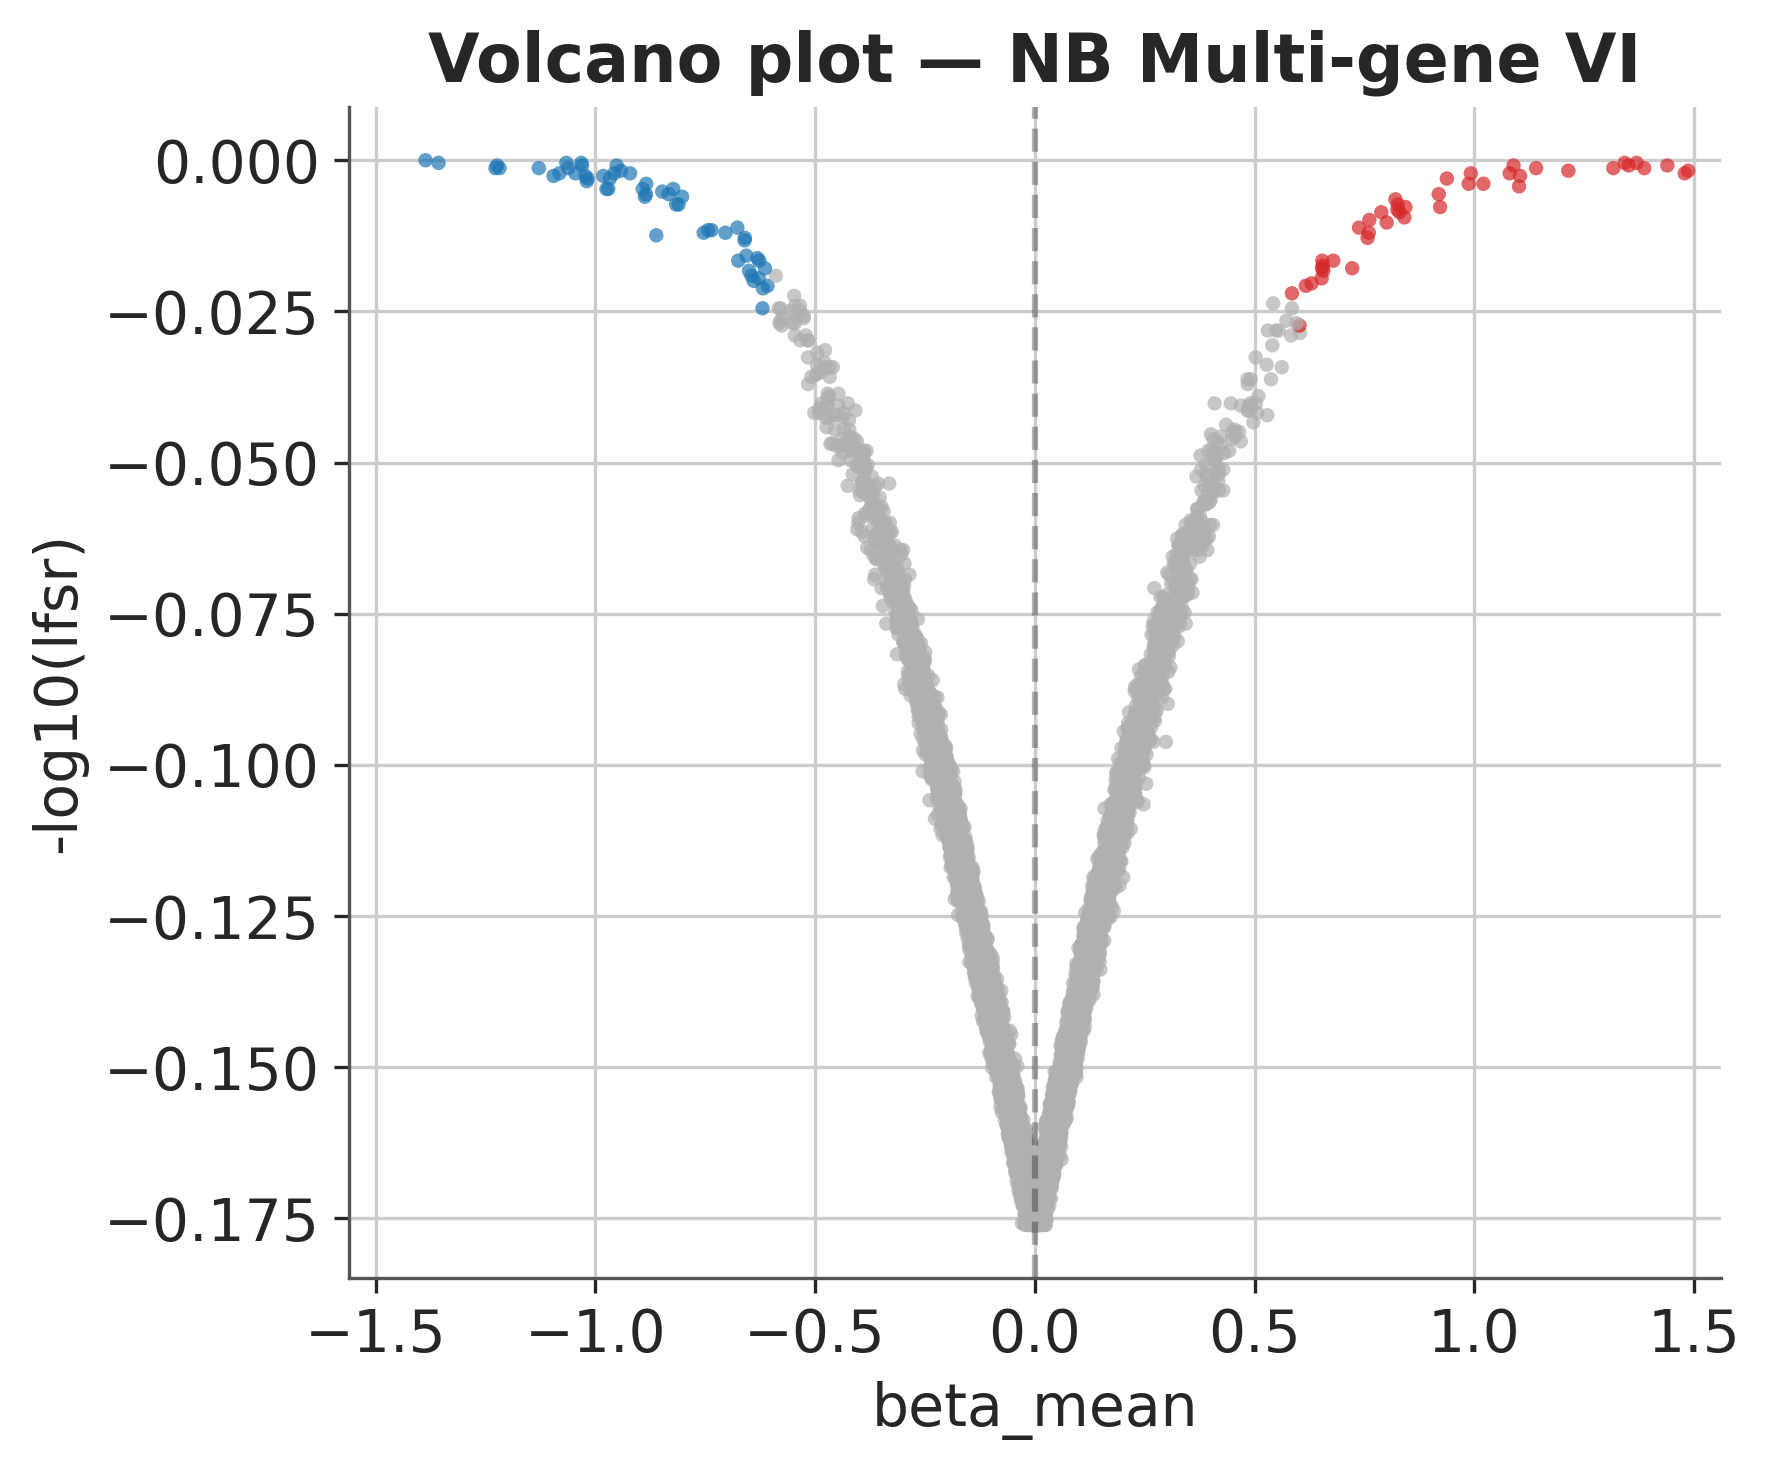

In [ ]:
# Volcano plot for HBM results with gray non-hits
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Paths from earlier cells
project_root = globals().get('project_root', Path('..').resolve().parent)
fig_dir = globals().get('fig_dir', project_root / 'outputs' / 'figures')
table_dir = globals().get('table_dir', project_root / 'outputs' / 'tables')
fig_dir.mkdir(parents=True, exist_ok=True)

# Input summary produced by HBM model
summary_path = table_dir / 'bayes_gene_summary_nb_multi_vi.csv'
assert summary_path.exists(), f"Missing: {summary_path} — run the HBM cell first."

df = pd.read_csv(summary_path)
if not {'gene','beta_mean','lfsr'}.issubset(df.columns):
    missing = {'gene','beta_mean','lfsr'} - set(df.columns)
    raise ValueError(f"Required columns missing in {summary_path.name}: {missing}")

# Try to load hits (preferred) or augmented summary to get a 'hit' flag
hit_flag = None
hits_path = table_dir / 'hits_nb_multi_vi.csv'
aug_summary = table_dir / 'bayes_gene_summary_nb_multi_vi_with_probs.csv'
LFSR_MAX = 0.1
BETA_ABS_THRESH = 0.3
PROB_MIN = 0.8
try:
    if hits_path.exists():
        hits_df = pd.read_csv(hits_path)[['gene','hit']]
        hit_flag = hits_df.set_index('gene')['hit'].astype(bool)
    elif aug_summary.exists():
        aug_df = pd.read_csv(aug_summary)
        if {'gene','lfsr','p_abs_beta_ge_0_5'}.issubset(aug_df.columns):
            aug_df['hit'] = (aug_df['lfsr'] <= LFSR_MAX) & (aug_df['p_abs_beta_ge_0_5'] >= PROB_MIN)
            hit_flag = aug_df.set_index('gene')['hit'].astype(bool)
except Exception as e:
    print(f"Warning: could not determine hit flags from files: {e}")

# Merge hit flag if available
if hit_flag is not None:
    df = df.merge(hit_flag.rename('hit'), on='gene', how='left')
else:
    df['hit'] = False

# Compute -log10(lfsr) safely
EPS = 1e-12
df = df.dropna(subset=['beta_mean','lfsr']).copy()
df['neglog_lfsr'] = -np.log10(np.clip(df['lfsr'].astype(float).values, EPS, 1.0) + 10e-1)

# Colors: gray for non-hits; for hits, red if beta_mean>0 else blue
colors = np.where(
    df['hit'].fillna(False).values,
    np.where(df['beta_mean'].astype(float).values > 0, '#d62728', '#1f77b4'),
    '#b0b0b0'
)
plt.figure(figsize=(6,5))
plt.scatter(df['beta_mean'].astype(float), df['neglog_lfsr'].astype(float), c=colors, s=12, alpha=0.7, linewidths=0)
plt.axvline(0, color='k', linestyle='--', alpha=0.3)
plt.xlabel('beta_mean')
plt.ylabel('-log10(lfsr)')
plt.title('Volcano plot — HBM VI')

# Symmetric x-limits around 0
xmax = float(np.nanmax(np.abs(df['beta_mean']))) if len(df) else 1.0
if np.isfinite(xmax) and xmax > 0:
    plt.xlim(-1.05 * xmax, 1.05 * xmax)

plt.tight_layout()

out_path = fig_dir / 'volcano_plot_nb_multi_vi.png'
plt.savefig(str(out_path), dpi=150, bbox_inches='tight')
print(f"Saved figure: {out_path}")
plt.show()

## Fast screening for NUTS

- Normalize counts using library-size size factors and use log(size_factor) as offset.
- Compute per-gene lightweight scores using only sgRNA counts:
  - baseMean of normalized counts
  - sgRNA LFC median, sign-consistency, MAD
  - simple NB/Poisson-GLM (non-hierarchical): Wald z/p for treatment effect
- Compose a rank: rank(p_Wald) + rank(-|median_LFC|) + rank(-sign_consistency)
- Use sample-split for guardrail: rep1 for screening, rep2 to confirm direction consistency
- Save:
  - outputs/tables/candidate_genes.csv
  - outputs/tables/tidy_counts_candidates.csv

In [ ]:
# candidates from sgRNA counts (MAGeCK-free)
import pandas as pd
import numpy as np
from pathlib import Path
from scipy import stats

# Inputs from earlier cells or define fallbacks
project_root = globals().get("project_root")
if project_root is None:
    project_root = Path.cwd().parents[2]

data_dir = globals().get("data_dir", project_root / "data")
table_dir = globals().get("table_dir", project_root / "outputs" / "tables")
fig_dir = globals().get("fig_dir", project_root / "outputs" / "figures")

table_dir.mkdir(parents=True, exist_ok=True)

# Expect counts_long to exist with updated DESeq2 size_factor
if 'counts_long' not in globals():
    raise RuntimeError("counts_long not found. Run tidy/QA cells first.")

# Parameters
C = 0.5  # pseudo-count for LFC
BASEMEAN_MIN = 10  # filter; relax to 5 if very sparse
TOP_K = 5000
BUFFER = 1000

# Build normalized counts per sample using DESeq2 size factors
counts_long = counts_long.copy()
counts_long['norm'] = counts_long['count'] / counts_long['size_factor']

# Split by replicate for sample-split guardrail (replicate is numeric: 1, 2)
rep1 = counts_long[counts_long['replicate'] == 1]
rep2 = counts_long[counts_long['replicate'] == 2]

# Helper to compute sgRNA-level LFC for a replicate-slice
def sgrna_lfc(df_slice: pd.DataFrame) -> pd.DataFrame:
    piv = df_slice.pivot_table(index=['sgrna','gene'], columns='condition', values='norm', aggfunc='sum').fillna(0.0)
    for col in ['control','treatment']:
        if col not in piv.columns:
            piv[col] = 0.0
    lfc = np.log2((piv['treatment'] + C) / (piv['control'] + C))
    return lfc.to_frame('lfc').reset_index()

lfc1 = sgrna_lfc(rep1)
lfc2 = sgrna_lfc(rep2)

# Per-gene aggregation
# - median LFC
# - MAD (Median Absolute Deviation): median(|x - median(x)|)
# - sign-consistency: share of sgRNAs whose sign matches gene-level median sign
# - n_sgrna: number of sgRNAs observed

def aggregate_gene_metrics(lfc_df: pd.DataFrame, label: str) -> pd.DataFrame:
    grp = lfc_df.groupby('gene')
    med = grp['lfc'].median().rename(f'median_lfc_{label}')
    # Robust MAD (median absolute deviation)
    mad_series = grp['lfc'].apply(lambda s: np.median(np.abs(s - np.median(s)))).rename(f'mad_lfc_{label}')
    # Gene-level median sign
    sign_med = np.sign(med).replace(0, 0)
    tmp = lfc_df.merge(sign_med.rename('sign_med'), left_on='gene', right_index=True, how='left')
    tmp['agree'] = np.sign(tmp['lfc']).replace(0, 0) == tmp['sign_med']
    sc = tmp.groupby('gene')['agree'].mean().rename(f'sign_consistency_{label}')
    n_sg = grp['lfc'].size().rename(f'n_sgrna_{label}')
    return pd.concat([med, mad_series, sc, n_sg], axis=1).reset_index()

agg1 = aggregate_gene_metrics(lfc1, 'r1')
agg2 = aggregate_gene_metrics(lfc2, 'r2')

# baseMean using normalized counts across both replicates and conditions
base = (
    counts_long
    .groupby(['gene','sgrna','sample_id'])['norm'].sum()
    .groupby('gene').mean()
    .rename('baseMean')
    .reset_index()
)

# Simple GLM per gene with Poisson link and offset log(size_factor)
from statsmodels.genmod.generalized_linear_model import GLM
from statsmodels.genmod import families
from statsmodels.tools import add_constant

wald_rows = []
for g, df in counts_long.groupby('gene'):
    try:
        X = pd.DataFrame({'treat': (df['condition'] == 'treatment').astype(int).values})
        X = add_constant(X, has_constant='add')
        y = df['count'].astype(float).values
        offset = np.log(df['size_factor'].values)
        model = GLM(y, X, family=families.Poisson(), offset=offset)
        res = model.fit(maxiter=50, disp=0)
        beta = res.params.get('treat', np.nan)
        se = res.bse.get('treat', np.nan)
        z = beta / se if (se is not None and se > 0) else np.nan
        p = 2 * (1 - stats.norm.cdf(abs(z))) if np.isfinite(z) else 1.0
        wald_rows.append({'gene': g, 'wald_beta': beta, 'wald_se': se, 'wald_z': z, 'wald_p': p})
    except Exception:
        wald_rows.append({'gene': g, 'wald_beta': np.nan, 'wald_se': np.nan, 'wald_z': np.nan, 'wald_p': 1.0})

wald = pd.DataFrame(wald_rows)

# Merge all metrics
metrics = base.merge(agg1, on='gene', how='left').merge(agg2, on='gene', how='left').merge(wald, on='gene', how='left')

# Primary metrics for ranking
metrics['n_sgrna'] = metrics[['n_sgrna_r1','n_sgrna_r2']].fillna(0).max(axis=1)
metrics['median_lfc'] = metrics[['median_lfc_r1','median_lfc_r2']].median(axis=1)
metrics['sign_consistency'] = metrics[['sign_consistency_r1','sign_consistency_r2']].median(axis=1)
metrics['mad_lfc'] = metrics[['mad_lfc_r1','mad_lfc_r2']].median(axis=1)

# Filters
keep = (metrics['baseMean'] >= BASEMEAN_MIN) & (metrics['n_sgrna'] >= 3)
metrics_f = metrics.loc[keep].copy()

# Composite rank (lower is better)
metrics_f['rank_p'] = metrics_f['wald_p'].rank(method='average')
metrics_f['rank_lfc'] = (-metrics_f['median_lfc'].abs()).rank(method='average')
metrics_f['rank_sc'] = (-metrics_f['sign_consistency']).rank(method='average')
metrics_f['composite_rank'] = metrics_f[['rank_p','rank_lfc','rank_sc']].sum(axis=1)

# Sample-split confirmation: direction consistency on rep2
metrics_f['confirm_sign_consistency'] = metrics_f['sign_consistency_r2']

# Select 
# 
# 
# 
#  K + buffer
K = TOP_K + BUFFER
candidates = metrics_f.sort_values('composite_rank').head(K).copy()

# Save candidate table
out_cand = table_dir / 'candidate_genes.csv'
candidates_cols = [
    'gene','baseMean','n_sgrna','median_lfc','sign_consistency','mad_lfc',
    'wald_beta','wald_se','wald_z','wald_p','composite_rank','confirm_sign_consistency'
]
candidates[candidates_cols].to_csv(out_cand, index=False)
print(f"Saved candidate genes: {out_cand} (n={len(candidates)})")

In [ ]:
# Restrict tidy counts to Stage-1 candidates and save
import pandas as pd

if 'counts_long' not in globals():
    raise RuntimeError("counts_long not found. Run tidy/QA cells first.")

cand_df = pd.read_csv(table_dir / "candidate_genes.csv")
keep_genes = set(cand_df['gene'].unique())
counts_candidates = counts_long[counts_long['gene'].isin(keep_genes)].copy()

out_tidy_cand = table_dir / "tidy_counts_candidates.csv"
counts_candidates.to_csv(out_tidy_cand, index=False)
print(f"Saved candidate tidy counts: {out_tidy_cand} (rows={len(counts_candidates):,})")

Saved candidate tidy counts: /Users/ryodaikim/Desktop/0.projects/CRISPR-bayes/outputs/tables/tidy_counts_candidates.csv (rows=96,216)


## NUTS sampling

Run full NUTS sampling on a manageable subset of genes to refine effects and uncertainty. Outputs are saved under `outputs/tables/` and posterior caches under `outputs/tables/posterior_cache_nb_multi_nuts/`.

In [ ]:
# NUTS refinement for a subset of genes (with optional resume/skip)
import numpy as np
import pandas as pd
import pymc as pm
import arviz as az
from pathlib import Path

# Inputs & outputs
project_root = globals().get('project_root', Path('..').resolve().parent)
table_dir = globals().get('table_dir', project_root / 'outputs' / 'tables')
fig_dir = globals().get('fig_dir', project_root / 'outputs' / 'figures')
fig_dir.mkdir(parents=True, exist_ok=True)
table_dir.mkdir(parents=True, exist_ok=True)

# Tidy counts must exist
assert 'counts_long' in globals(), "counts_long not found. Run preprocessing cells first."

# Optional resume behavior
SKIP_ALREADY_SAMPLED = True  # If True, filter out genes already present in the existing NUTS summary
NUTS_SUMMARY_PATH = table_dir / 'bayes_gene_summary_nb_multi_nuts.csv'

# Selection of genes for NUTS
# Priority: NB hits → Stage-1 candidates → top by VI lfsr → manual list
# Set sufficiently large to allow sampling all candidates (e.g., 6000)
nuts_max_genes = 6000  # adjust as needed
sel_genes = []

hits_path = table_dir / 'hits_nb_multi_vi.csv'
cands_path = table_dir / 'candidate_genes.csv'
vi_sum_path = table_dir / 'bayes_gene_summary_nb_multi_vi.csv'

if hits_path.exists():
    hits_df = pd.read_csv(hits_path)
    hits_df = hits_df[hits_df.get('hit', False) == True]
    sel_genes = hits_df['gene'].astype(str).unique().tolist()
    print(f"Selected from NB hits: {len(sel_genes)}")

if (len(sel_genes) == 0) and cands_path.exists():
    cdf = pd.read_csv(cands_path)
    sel_genes = cdf['gene'].astype(str).unique().tolist()
    print(f"Selected from Stage-1 candidates: {len(sel_genes)}")

if (len(sel_genes) == 0) and vi_sum_path.exists():
    vs = pd.read_csv(vi_sum_path)
    if 'lfsr' in vs.columns:
        vs = vs.dropna(subset=['lfsr']).sort_values('lfsr', ascending=True)
        sel_genes = vs['gene'].astype(str).head(nuts_max_genes).tolist()
        print(f"Selected top by VI lfsr: {len(sel_genes)}")

# Resume/skip: remove any genes that are already in the existing NUTS summary
if SKIP_ALREADY_SAMPLED and NUTS_SUMMARY_PATH.exists() and len(sel_genes) > 0:
    prev = pd.read_csv(NUTS_SUMMARY_PATH)
    prev_genes = set(prev['gene'].astype(str)) if 'gene' in prev.columns else set()
    before = len(sel_genes)
    sel_genes = [g for g in sel_genes if g not in prev_genes]
    skipped = before - len(sel_genes)
    print(f"Skipping {skipped} genes already sampled (found in NUTS summary). Remaining: {len(sel_genes)}")

# Optionally limit the number of genes for NUTS
if len(sel_genes) > nuts_max_genes:
    sel_genes = sel_genes[:nuts_max_genes]
print(f"NUTS target genes: {len(sel_genes)}")
if len(sel_genes) == 0:
    raise RuntimeError("No genes selected for NUTS after applying filters. Adjust selection or disable SKIP_ALREADY_SAMPLED.")

# Prepare modeling data
counts_model = counts_long[counts_long['gene'].astype(str).isin(sel_genes)].copy()
counts_model['gene'] = counts_model['gene'].astype(str)
counts_model['sgrna'] = counts_model['sgrna'].astype(str)
counts_model['sample_id'] = counts_model['sample_id'].astype(str)

# Centered treatment coding per sample
sample_ref = counts_model[['sample_id','condition']].drop_duplicates()
sample_ref['treat'] = (sample_ref['condition'].astype(str) == 'treatment').astype(int)
sample_ref['x_centered'] = sample_ref['treat'] - sample_ref['treat'].mean()
counts_model = counts_model.merge(sample_ref[['sample_id','x_centered']], on='sample_id', how='left')

# Indices
gene_codes = pd.Categorical(counts_model['gene'])
G = len(gene_codes.categories)
gene_idx = gene_codes.codes.astype('int64')

sg_pair = counts_model['gene'].astype(str) + '||' + counts_model['sgrna'].astype(str)
sg_codes = pd.Categorical(sg_pair)
S = len(sg_codes.categories)
sg_idx = sg_codes.codes.astype('int64')

smp_codes = pd.Categorical(counts_model['sample_id'].astype(str))
R = len(smp_codes.categories)
smp_idx = smp_codes.codes.astype('int64')

x = counts_model['x_centered'].astype(float).values
offset = np.log(counts_model['size_factor'].astype(float).values + 1e-12)
y = counts_model['count'].astype('int64').values

# Hyperparameters (reuse from VI stage for consistency)
SIGMA_GAMMA = 1.5
TAU_BETA_PRIOR = 1.0
TAU_U_PRIOR = 1.0
PHI_HN_SCALE = 2.0

# NUTS sampling config
CHAINS = 2
DRAWS = 1000
TUNE = 1000
TARGET_ACCEPT = 0.9
RANDOM_SEED = 20251012

with pm.Model() as model:
    # Priors
    gamma_g = pm.Normal('gamma_g', mu=0.0, sigma=SIGMA_GAMMA, shape=G)
    tau_beta = pm.HalfNormal('tau_beta', sigma=TAU_BETA_PRIOR)
    beta_g = pm.Normal('beta_g', mu=0.0, sigma=tau_beta, shape=G)
    tau_u = pm.HalfNormal('tau_u', sigma=TAU_U_PRIOR)
    u_sg = pm.Normal('u_sg', mu=0.0, sigma=tau_u, shape=S)
    r_raw = pm.Normal('r_raw', mu=0.0, sigma=0.5, shape=R)
    r = pm.Deterministic('r', r_raw - pm.math.mean(r_raw))
    phi = pm.HalfNormal('phi', sigma=PHI_HN_SCALE)

    eta = offset + gamma_g[gene_idx] + beta_g[gene_idx] * x + u_sg[sg_idx] + r[smp_idx]
    mu = pm.Deterministic('mu', pm.math.exp(eta))
    pm.NegativeBinomial('y', mu=mu, alpha=phi, observed=y)

    idata = pm.sample(
        draws=DRAWS,
        tune=TUNE,
        chains=CHAINS,
        target_accept=TARGET_ACCEPT,
        random_seed=RANDOM_SEED,
        compute_convergence_checks=True,
        progressbar=True,
    )

# Summaries
post = idata.posterior
beta_draws = np.asarray(post['beta_g'])  # (chain, draw, G)
beta_flat = beta_draws.reshape(-1, beta_draws.shape[-1])
psp = (beta_flat > 0).mean(axis=0)
lfsr = np.minimum(psp, 1 - psp)
beta_mean = beta_flat.mean(axis=0)
beta_sd = beta_flat.std(axis=0, ddof=1)

# Map back to gene names
genes_in_set = list(gene_codes.categories.astype(str))

nuts_summary_rows = []
for j, gname in enumerate(genes_in_set):
    n_obs_g = int((gene_idx == j).sum())
    n_sg_g = int(counts_model.loc[counts_model['gene'].astype(str) == gname, 'sgrna'].nunique())
    nuts_summary_rows.append({
        'gene': gname,
        'beta_mean_nuts': float(beta_mean[j]),
        'beta_sd_nuts': float(beta_sd[j]),
        'psp_nuts': float(psp[j]),
        'lfsr_nuts': float(lfsr[j]),
        'n_obs': n_obs_g,
        'n_sgrna': n_sg_g,
        'n_sample': R,
        'chains': CHAINS,
        'draws': DRAWS,
        'tune': TUNE,
    })

nuts_summary = pd.DataFrame(nuts_summary_rows)
if not NUTS_SUMMARY_PATH.exists():
    nuts_summary.to_csv(NUTS_SUMMARY_PATH, index=False)
else:
    # update/merge existing rows for same genes, keeping previous values unless missing
    prev = pd.read_csv(NUTS_SUMMARY_PATH)
    keep_cols = list(nuts_summary.columns)
    merged = (
        prev[keep_cols]
        .set_index('gene')
        .combine_first(nuts_summary.set_index('gene'))
        .reset_index()
    )
    merged.to_csv(NUTS_SUMMARY_PATH, index=False)
print(f"Saved NUTS summary: {NUTS_SUMMARY_PATH} (n={len(nuts_summary)})")

# Save posterior beta draws cache for NUTS (current run subset)
posterior_cache_nuts_dir = table_dir / 'posterior_cache_nb_multi_nuts'
posterior_cache_nuts_dir.mkdir(parents=True, exist_ok=True)
cache_path = posterior_cache_nuts_dir / 'beta_draws_nuts_subset.npz'

np.savez_compressed(cache_path, beta=beta_flat.astype(np.float32), genes=np.array(genes_in_set, dtype='U'))
print(f"Saved NUTS beta draws cache: {cache_path}")

## Joint-batch NUTS sampling

This section samples a batch of genes jointly under the HBM and writes a consolidated cache per batch:
- Single NPZ per batch: `outputs/tables/posterior_cache_nb_multi_nuts/beta_draws_batch_{BATCH_NO:04d}.npz`
  - Arrays: `beta` (draws × G_batch), `genes` (G_batch)
- Summary CSV is updated/merged: `outputs/tables/bayes_gene_summary_nb_multi_nuts.csv`
- Resume-safe: skips genes already present in the summary unless `OVERWRITE_EXISTING=True`.

Parameters to adjust in the next cell:
- `BATCH_SIZE_NUTS` (default 300)
- `TOTAL_TARGET` (default 6000)
- `SKIP_ALREADY_SAMPLED` (default True)
- `OVERWRITE_EXISTING` (default False)
- Sampler hyperparameters: `CHAINS`, `DRAWS`, `TUNE`, `TARGET_ACCEPT`

In [ ]:
# Joint-batch NUTS sampler for HBM: sample G_batch genes jointly, save consolidated NPZ per batch
import numpy as np
import pandas as pd
import pymc as pm
from pathlib import Path

# IO
project_root = globals().get('project_root', Path('..').resolve().parent)
table_dir = globals().get('table_dir', project_root / 'outputs' / 'tables')
fig_dir = globals().get('fig_dir', project_root / 'outputs' / 'figures')
fig_dir.mkdir(parents=True, exist_ok=True)
table_dir.mkdir(parents=True, exist_ok=True)
cache_dir = table_dir / 'posterior_cache_nb_multi_nuts'
cache_dir.mkdir(parents=True, exist_ok=True)

# Parameters
BATCH_SIZE_NUTS = 300           # genes per joint batch
TOTAL_TARGET = 6000               # total target across runs
SKIP_ALREADY_SAMPLED = True
OVERWRITE_EXISTING = False

# Files
CAND_PATH = table_dir / 'candidate_genes.csv'
NUTS_SUMMARY_PATH = table_dir / 'bayes_gene_summary_nb_multi_nuts.csv'

# Preconditions
assert 'counts_long' in globals(), "counts_long not found. Run preprocessing cells first."
if not CAND_PATH.exists():
    raise FileNotFoundError(f"Missing candidate gene list: {CAND_PATH}")

candidates = pd.read_csv(CAND_PATH)
if 'gene' not in candidates.columns:
    raise ValueError("candidate_genes.csv must include 'gene' column")
all_candidates = candidates['gene'].astype(str).dropna().unique().tolist()

prev = pd.read_csv(NUTS_SUMMARY_PATH) if NUTS_SUMMARY_PATH.exists() else pd.DataFrame(columns=['gene'])
prev_genes = set(prev['gene'].astype(str)) if 'gene' in prev.columns else set()

ahead = len(prev_genes & set(all_candidates))
remaining_total = max(TOTAL_TARGET - ahead, 0)
if remaining_total == 0:
    print(f"Target of {TOTAL_TARGET} already reached (or no remaining). Nothing to do.")
else:
    # Select next batch
    remaining = [g for g in all_candidates if (not SKIP_ALREADY_SAMPLED) or (g not in prev_genes)]
    if not remaining:
        raise RuntimeError("No remaining candidate genes to sample after applying skip filter.")
    take = min(BATCH_SIZE_NUTS, remaining_total, len(remaining))
    batch_genes = remaining[:take]
    print(f"Joint-sampling batch of {len(batch_genes)} genes (already done: {ahead}, remaining to target: {remaining_total})")

    # Subset data for the batch
    df = counts_long[counts_long['gene'].astype(str).isin(batch_genes)].copy()
    if df.empty:
        raise RuntimeError("No counts for selected batch genes.")

    df['sgrna'] = df['sgrna'].astype(str)
    df['sample_id'] = df['sample_id'].astype(str)
    df['sg_pair'] = df['gene'].astype(str) + '||' + df['sgrna'].astype(str)

    # center treatment per sample
    sample_ref = df[['sample_id','condition']].drop_duplicates()
    sample_ref['treat'] = (sample_ref['condition'].astype(str) == 'treatment').astype(int)
    sample_ref['x_centered'] = sample_ref['treat'] - sample_ref['treat'].mean()
    df = df.merge(sample_ref[['sample_id','x_centered']], on='sample_id', how='left')

    # Indices
    sg_codes = pd.Categorical(df['sg_pair'])
    S = len(sg_codes.categories)
    sg_idx = sg_codes.codes.astype('int64')

    smp_codes = pd.Categorical(df['sample_id'])
    R = len(smp_codes.categories)
    smp_idx = smp_codes.codes.astype('int64')

    gene_codes = pd.Categorical(df['gene'].astype(str), categories=batch_genes)
    G = len(gene_codes.categories)
    g_idx = gene_codes.codes.astype('int64')

    x = df['x_centered'].astype(float).values
    offset = np.log(df['size_factor'].astype(float).values + 1e-12)
    y = df['count'].astype('int64').values

    # Sampler hyperparameters
    CHAINS = 2
    DRAWS = 1000
    TUNE = 1000
    TARGET_ACCEPT = 0.9
    RANDOM_SEED = 20251013
    SIGMA_GAMMA = 1.5
    TAU_BETA_PRIOR = 1.0
    TAU_U_PRIOR = 1.0
    PHI_HN_SCALE = 2.0

    with pm.Model() as model:
        # Priors
        gamma = pm.Normal('gamma', mu=0.0, sigma=SIGMA_GAMMA, shape=G)  # per-gene intercept
        tau_beta = pm.HalfNormal('tau_beta', sigma=TAU_BETA_PRIOR)
        beta = pm.Normal('beta', mu=0.0, sigma=tau_beta, shape=G)       # per-gene treatment effect
        tau_u = pm.HalfNormal('tau_u', sigma=TAU_U_PRIOR)
        u_sg = pm.Normal('u_sg', mu=0.0, sigma=tau_u, shape=S)          # per-sg effect
        r_raw = pm.Normal('r_raw', mu=0.0, sigma=0.5, shape=R)
        r = pm.Deterministic('r', r_raw - pm.math.mean(r_raw))          # centered sample effect
        phi = pm.HalfNormal('phi', sigma=PHI_HN_SCALE)

        eta = offset + gamma[g_idx] + beta[g_idx] * x + u_sg[sg_idx] + r[smp_idx]
        mu = pm.Deterministic('mu', pm.math.exp(eta))
        pm.NegativeBinomial('y', mu=mu, alpha=phi, observed=y)

        idata = pm.sample(
            draws=DRAWS,
            tune=TUNE,
            chains=CHAINS,
            target_accept=TARGET_ACCEPT,
            random_seed=RANDOM_SEED,
            compute_convergence_checks=True,
            progressbar=True,
        )

    post = idata.posterior
    beta_draws = np.asarray(post['beta']).reshape(-1, G)

    # summarize per gene
    psp_list = (beta_draws > 0).mean(axis=0)
    lfsr_list = np.minimum(psp_list, 1.0 - psp_list)
    beta_mean = beta_draws.mean(axis=0)
    beta_sd = beta_draws.std(axis=0, ddof=1)

    rows = []
    cats = list(gene_codes.categories)
    for j, g in enumerate(cats):
        if pd.isna(g):
            continue
        rows.append({
            'gene': str(g),
            'beta_mean_nuts': float(beta_mean[j]),
            'beta_sd_nuts': float(beta_sd[j]),
            'psp_nuts': float(psp_list[j]),
            'lfsr_nuts': float(lfsr_list[j]),
            'n_obs': int((g_idx == j).sum()),
            'n_sgrna': int(df.loc[g_idx == j, 'sgrna'].nunique()),
            'n_sample': int(R),
            'chains': CHAINS,
            'draws': DRAWS,
            'tune': TUNE,
        })

    out_df = pd.DataFrame(rows)
    # merge into summary
    if not NUTS_SUMMARY_PATH.exists():
        out_df.to_csv(NUTS_SUMMARY_PATH, index=False)
    else:
        prev = pd.read_csv(NUTS_SUMMARY_PATH)
        keep_cols = list(set(prev.columns) | set(out_df.columns))
        prev = prev.reindex(columns=keep_cols)
        out_df = out_df.reindex(columns=keep_cols)
        if OVERWRITE_EXISTING:
            merged = prev.set_index('gene').combine_first(pd.DataFrame()).reset_index()
            merged = out_df.set_index('gene').combine_first(merged.set_index('gene')).reset_index()
        else:
            merged = prev.set_index('gene').combine_first(out_df.set_index('gene')).reset_index()
        merged.to_csv(NUTS_SUMMARY_PATH, index=False)
    print(f"Saved/updated NUTS summary: {NUTS_SUMMARY_PATH} (+{len(out_df)} genes)")

    # Save consolidated NPZ per batch
    existing = sorted(cache_dir.glob('beta_draws_batch_*.npz'))
    batch_no = len(existing) + 1
    cache_path = cache_dir / f"beta_draws_batch_{batch_no:04d}.npz"
    np.savez_compressed(cache_path, beta=beta_draws.astype(np.float32), genes=np.array(cats, dtype=object))
    print(f"Saved NUTS beta draws cache: {cache_path}")

Joint-sampling batch of 100 genes (already done: 2900, remaining to target: 3100)


Initializing NUTS using jitter+adapt_diag...


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [gamma, tau_beta, beta, tau_u, u_sg, r_raw, phi]


Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 85 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


Saved/updated NUTS summary: /Users/ryodaikim/Desktop/0.projects/CRISPR-bayes/outputs/tables/bayes_gene_summary_nb_multi_nuts.csv (+100 genes)
Saved NUTS beta draws cache: /Users/ryodaikim/Desktop/0.projects/CRISPR-bayes/outputs/tables/posterior_cache_nb_multi_nuts/beta_draws_batch_0010.npz


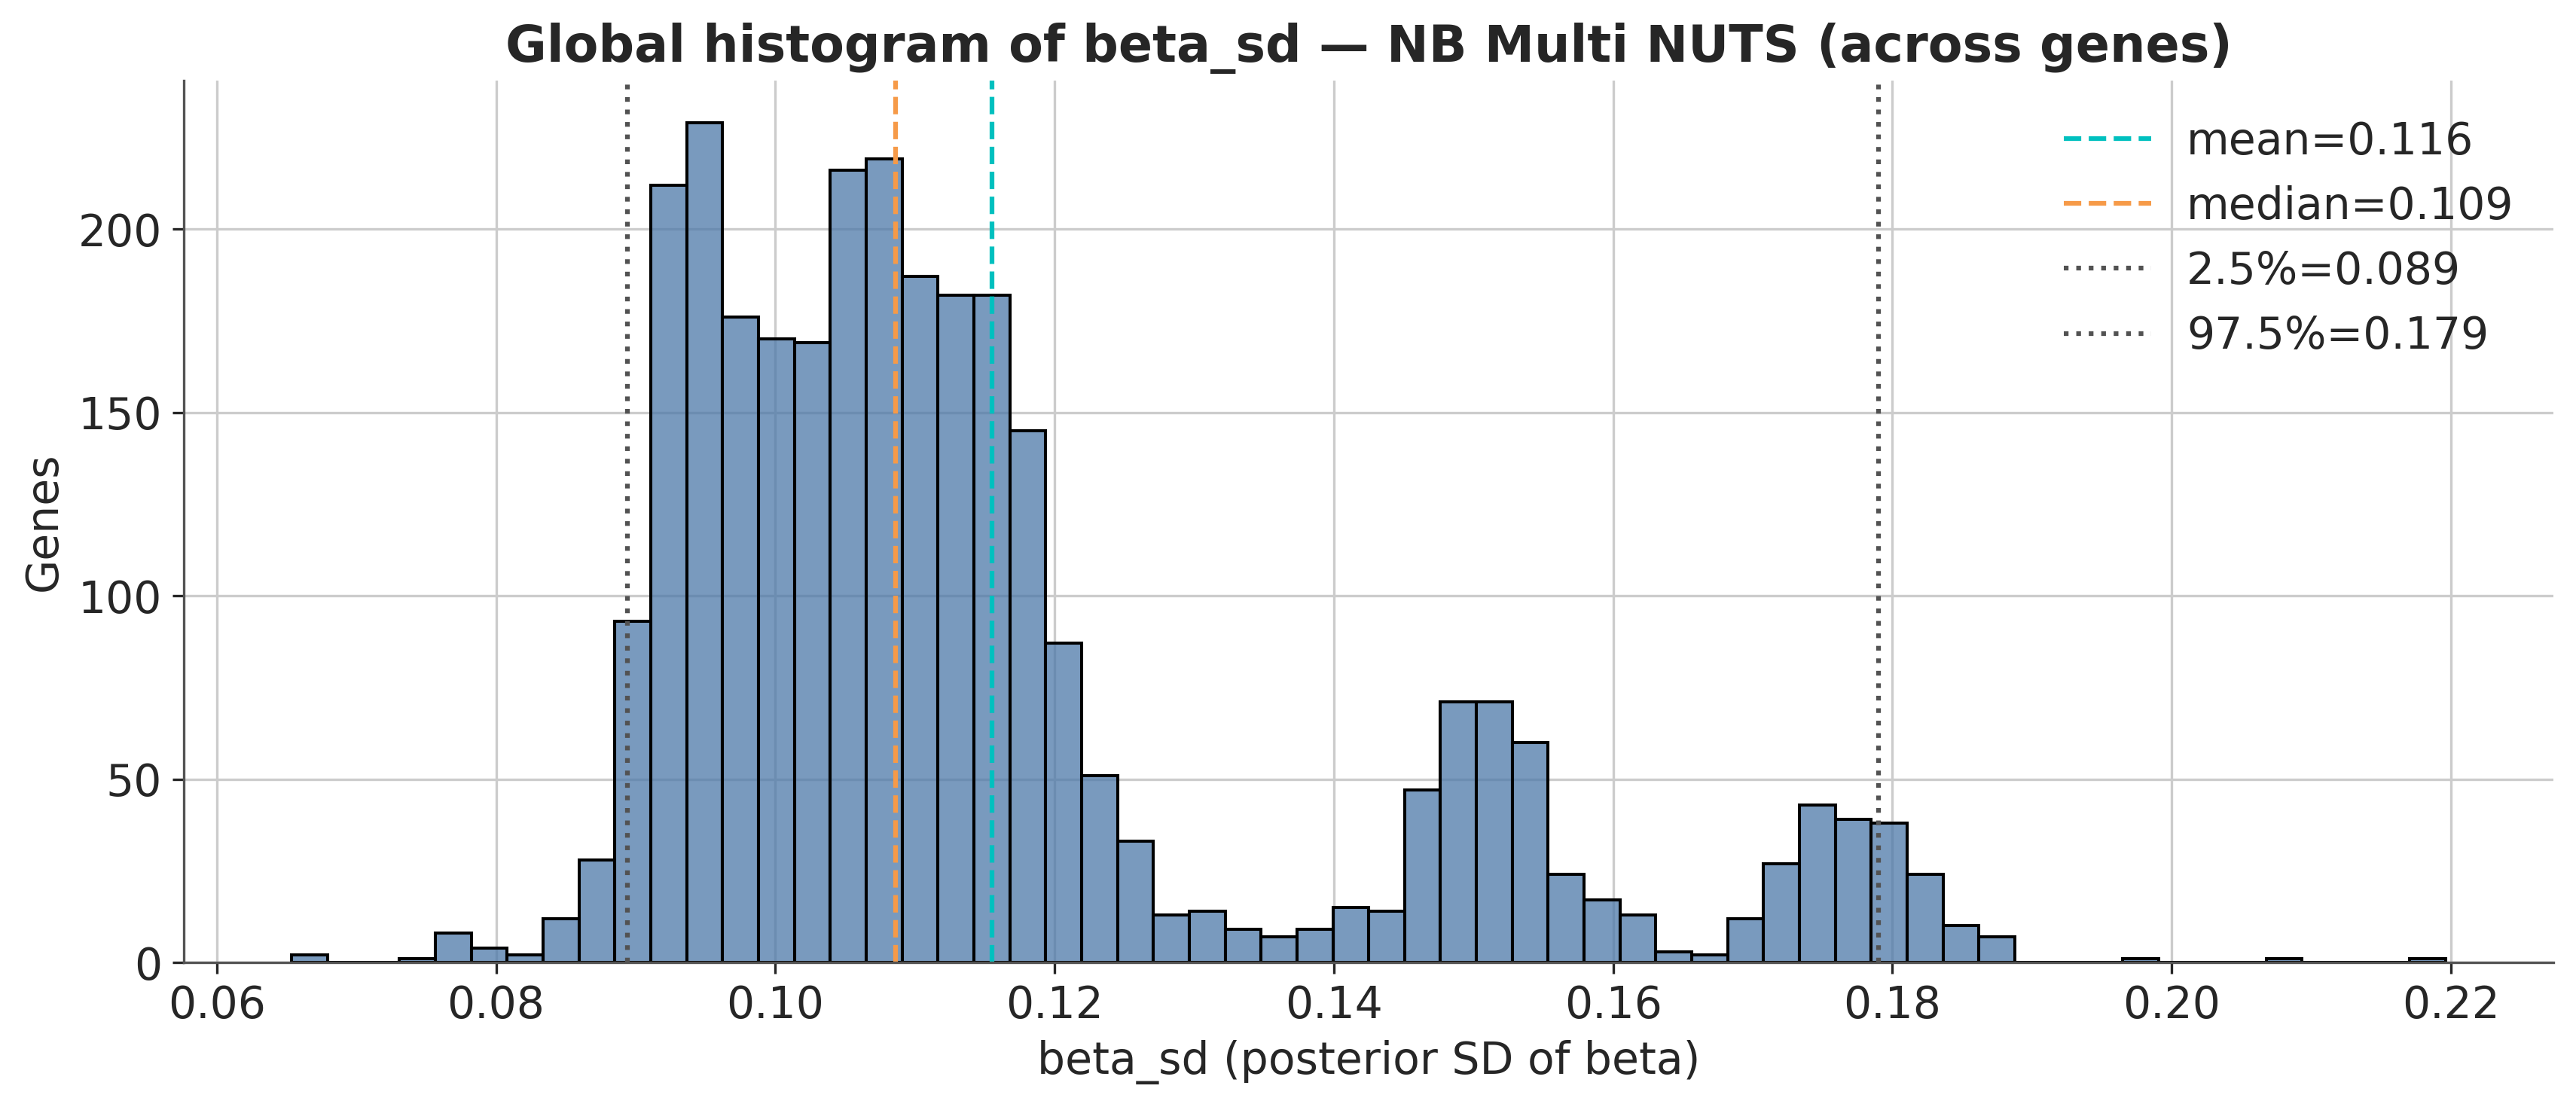

Saved beta_sd global histogram: /Users/ryodaikim/Desktop/0.projects/CRISPR-bayes/outputs/figures/beta_sd_hist_global_nb_multi_nuts.png


In [ ]:
# Global histogram of beta_sd for HBM NUTS across genes
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

project_root = globals().get('project_root', Path('..').resolve().parent)
table_dir = globals().get('table_dir', project_root / 'outputs' / 'tables')
fig_dir = globals().get('fig_dir', project_root / 'outputs' / 'figures')
fig_dir.mkdir(parents=True, exist_ok=True)

nuts_summary_path = table_dir / 'bayes_gene_summary_nb_multi_nuts.csv'
if not nuts_summary_path.exists():
    raise FileNotFoundError(f"Missing NUTS summary: {nuts_summary_path}")

sum_df = pd.read_csv(nuts_summary_path)
col = None
for cand in ['beta_sd_nuts', 'beta_sd']:
    if cand in sum_df.columns:
        col = cand
        break
if col is None:
    raise ValueError("NUTS summary missing beta_sd column ('beta_sd_nuts' or 'beta_sd').")

sd = sum_df[col].astype(float).replace([np.inf, -np.inf], np.nan).dropna().values
if sd.size == 0:
    raise RuntimeError("No finite beta_sd values found in NUTS summary.")

m_mean = float(np.mean(sd))
m_med = float(np.median(sd))
lo, hi = np.quantile(sd, [0.025, 0.975])

sns.histplot(sd, bins=60, kde=False, color='#4C78A8')
plt.axvline(m_mean, color='C1', linestyle='--', label=f'mean={m_mean:.3f}')
plt.axvline(m_med, color='C2', linestyle='--', label=f'median={m_med:.3f}')
plt.axvline(lo, color='C6', linestyle=':', label=f'2.5%={lo:.3f}')
plt.axvline(hi, color='C6', linestyle=':', label=f'97.5%={hi:.3f}')
plt.title('Global histogram of beta_sd — HBM NUTS')
plt.xlabel('beta_sd (posterior SD of beta)')
plt.ylabel('Genes')
plt.legend()
out_path = fig_dir / 'beta_sd_hist_global_nb_multi_nuts.png'
plt.tight_layout()
plt.savefig(out_path, dpi=150)
plt.show()
print(f"Saved beta_sd global histogram: {out_path}")

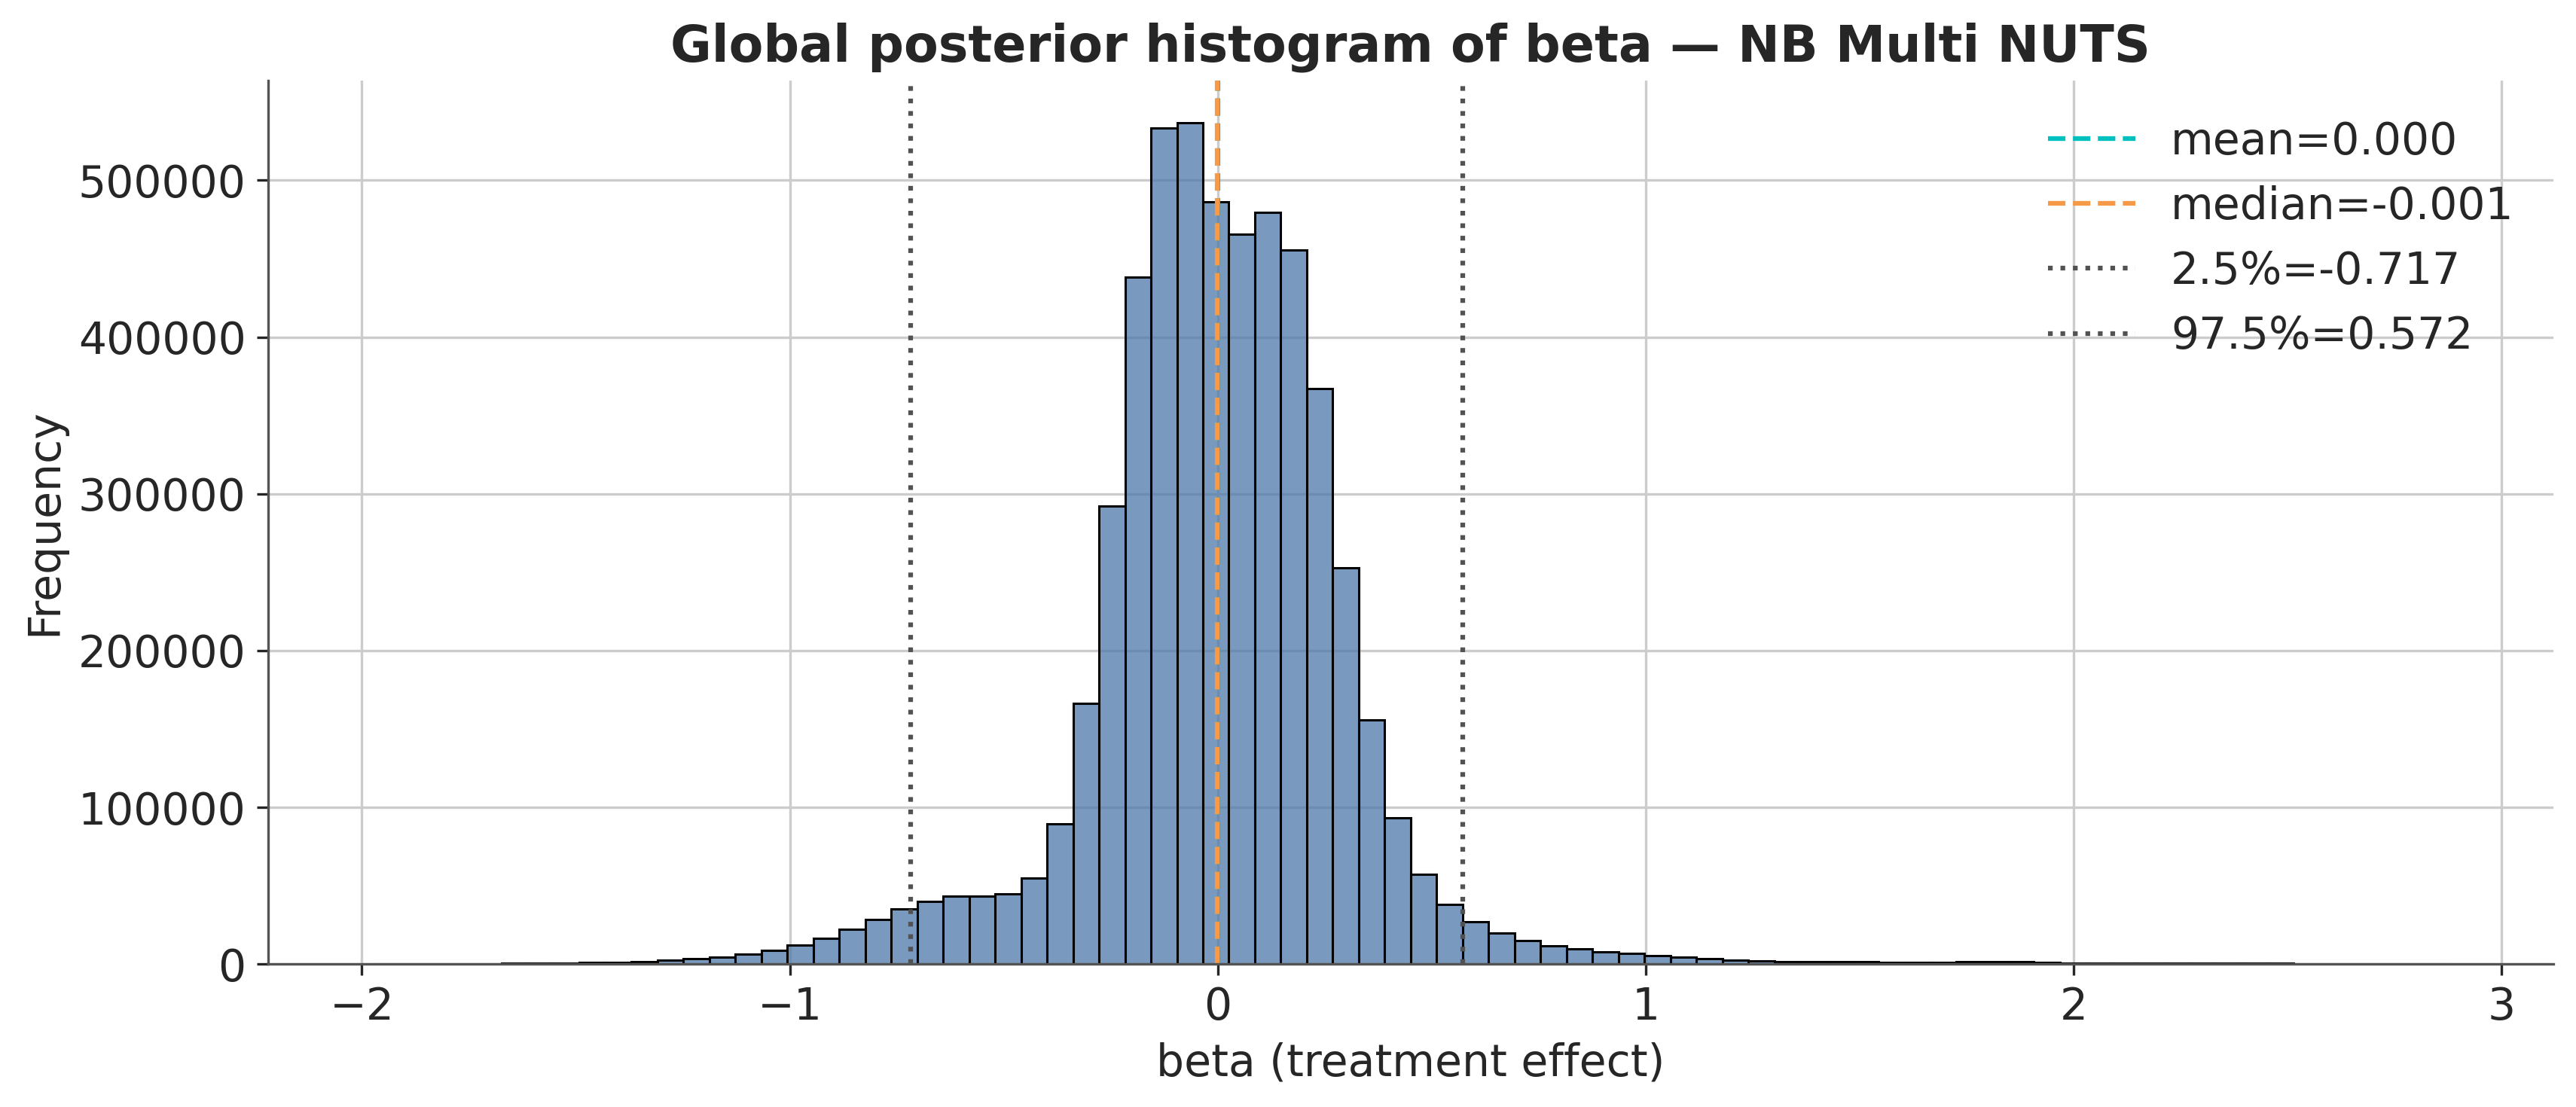

Saved global posterior histogram: /Users/ryodaikim/Desktop/0.projects/CRISPR-bayes/outputs/figures/posterior_hist_global_nb_multi_nuts.png


In [ ]:
# Global histogram of beta for HBM NUTS (aggregate per-gene and batch caches)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

project_root = globals().get('project_root', Path('..').resolve().parent)
table_dir = globals().get('table_dir', project_root / 'outputs' / 'tables')
fig_dir = globals().get('fig_dir', project_root / 'outputs' / 'figures')
fig_dir.mkdir(parents=True, exist_ok=True)
posterior_cache_dir = table_dir / 'posterior_cache_nb_multi_nuts'

if not posterior_cache_dir.exists():
    raise FileNotFoundError(f"Missing posterior cache dir: {posterior_cache_dir}. Run NUTS sampling first.")

all_draws = []
cache_files = sorted(posterior_cache_dir.glob('beta_draws_*.npz'))
if not cache_files:
    # legacy single-file
    cache_files = [posterior_cache_dir / 'beta_draws_nuts_subset.npz']

for npz_path in cache_files:
    try:
        z = np.load(npz_path, allow_pickle=True)
        if 'beta' in z and 'genes' in z:
            beta = np.asarray(z['beta'])
            if beta.ndim == 1:
                beta = beta.reshape(-1, 1)
            all_draws.append(beta.reshape(-1))
        elif 'beta' in z:
            beta = np.asarray(z['beta']).reshape(-1)
            all_draws.append(beta)
        else:
            print(f"[warn] skipping cache without beta: {npz_path}")
    except Exception as e:
        print(f"[warn] failed to read {npz_path}: {e}")

if not all_draws:
    raise RuntimeError("No beta draws found in caches. Run NUTS sampler to generate per-gene NPZ files.")

beta_flat = np.concatenate(all_draws).astype(float)
m_mean = float(np.mean(beta_flat))
m_med = float(np.median(beta_flat))
lo, hi = np.quantile(beta_flat, [0.025, 0.975])

sns.histplot(beta_flat, bins=80, kde=False, color='#4C78A8')
plt.axvline(m_mean, color='C1', linestyle='--', label=f'mean={m_mean:.3f}')
plt.axvline(m_med, color='C2', linestyle='--', label=f'median={m_med:.3f}')
plt.axvline(lo, color='C6', linestyle=':', label=f'2.5%={lo:.3f}')
plt.axvline(hi, color='C6', linestyle=':', label=f'97.5%={hi:.3f}')
plt.title('Global posterior histogram of beta — HBM NUTS')
plt.xlabel('beta (treatment effect)')
plt.ylabel('Frequency')
plt.legend()
out_path = fig_dir / 'posterior_hist_global_nb_multi_nuts.png'
plt.tight_layout()
plt.savefig(out_path, dpi=150)
plt.show()
print(f"Saved global posterior histogram: {out_path}")

In [ ]:
# Hit calling for HBM NUTS results (using exact posterior draws)
import pandas as pd
import numpy as np
from pathlib import Path

# IO paths
project_root = globals().get('project_root', Path('..').resolve().parent)
table_dir = globals().get('table_dir', project_root / 'outputs' / 'tables')
summary_path = table_dir / 'bayes_gene_summary_nb_multi_nuts.csv'
posterior_cache_dir = table_dir / 'posterior_cache_nb_multi_nuts'

if not summary_path.exists():
    raise FileNotFoundError(f"Missing NUTS summary: {summary_path}. Run the NUTS refinement cell first.")
if not posterior_cache_dir.exists():
    raise FileNotFoundError(f"Missing posterior cache dir: {posterior_cache_dir}. Run the NUTS refinement cell to save caches.")

# Load summary
gsum = pd.read_csv(summary_path)
if 'gene' not in gsum.columns:
    raise ValueError('NUTS summary must include gene column')

genes = gsum['gene'].astype(str).tolist()

# Decision thresholds (same as VI)
LFSR_MAX = .05
BETA_ABS_THRESH = 0.3
ALT_ABS_THRESH = 0.5
PROB_MIN = 0.85

# Gather exact posterior draws from NUTS cache file(s)
beta_draws_map = {}
cache_files = sorted(posterior_cache_dir.glob('beta_draws_*.npz'))
if not cache_files:
    # Backward-compat single-file cache
    cache_files = [posterior_cache_dir / 'beta_draws_nuts_subset.npz']

for npz_path in cache_files:
    if not npz_path.exists():
        continue
    try:
        z = np.load(npz_path, allow_pickle=True)
        # Batch caches: expect 'beta' (draws x G) and 'genes' (G)
        if 'beta' in z and 'genes' in z:
            beta = z['beta']
            genes_batch = [str(g) for g in np.array(z['genes']).tolist()]
            # If 1-D beta (per-gene cache), expand dims to (draws, 1)
            if beta.ndim == 1:
                beta = beta.reshape(-1, 1)
            if beta.shape[-1] != len(genes_batch):
                print(f"Warning: beta shape {beta.shape} mismatches genes ({len(genes_batch)}) in {npz_path}")
            for j, g in enumerate(genes_batch):
                if j < beta.shape[-1]:
                    beta_draws_map[g] = beta[:, j]
        # Per-gene caches with explicit 'gene' key
        elif 'beta' in z and 'gene' in z:
            beta = z['beta']
            gene_name = str(np.array(z['gene']).tolist()[0])
            beta_draws_map[gene_name] = beta.reshape(-1)
        # Per-gene caches without 'gene' key (infer from filename: beta_draws_{GENE}.npz)
        elif 'beta' in z:
            beta = z['beta']
            stem = npz_path.stem
            gene_name = stem.replace('beta_draws_', '', 1)
            if not gene_name or gene_name == stem:
                print(f"Warning: could not infer gene from filename: {npz_path}")
                continue
            beta_draws_map[str(gene_name)] = beta.reshape(-1)
        else:
            print(f"Warning: cache missing expected arrays: {npz_path}")
    except Exception as e:
        print(f"Warning: failed to read cache {npz_path}: {e}")

if not beta_draws_map:
    raise RuntimeError("No posterior draws found for NUTS. Re-run the NUTS refinement cell to generate caches.")

# Overlap diagnostics
genes_set = set(genes)
cache_set = set(beta_draws_map.keys())
common_genes = sorted(genes_set & cache_set)
print(f"Genes in NUTS summary: {len(genes_set):,}; with draws: {len(cache_set):,}; overlap: {len(common_genes):,}")

# Compute probabilities from draws
p_abs_main = []   # P(|beta| >= 0.3)
p_abs_alt = []    # P(|beta| >= 0.5)
p_pos = []
p_neg = []
psp_draws = []
lfsr_draws = []

for g in genes:
    draws = beta_draws_map.get(g)
    if draws is None or len(draws) == 0:
        p_abs_main.append(np.nan)
        p_abs_alt.append(np.nan)
        p_pos.append(np.nan)
        p_neg.append(np.nan)
        psp_draws.append(np.nan)
        lfsr_draws.append(np.nan)
    else:
        d = np.asarray(draws, dtype=float)
        p_abs_main.append(float((np.abs(d) >= BETA_ABS_THRESH).mean()))
        p_abs_alt.append(float((np.abs(d) >= ALT_ABS_THRESH).mean()))
        p_pos_val = float((d > 0).mean())
        p_pos.append(p_pos_val)
        p_neg.append(float((d < 0).mean()))
        psp_draws.append(p_pos_val)
        lfsr_draws.append(float(min(p_pos_val, 1.0 - p_pos_val)))

# Attach to summary
gsum = gsum.copy()
gsum['p_abs_beta_ge_0_3'] = p_abs_main
gsum['p_abs_beta_ge_0_5'] = p_abs_alt
gsum['p_beta_gt_0'] = p_pos
gsum['p_beta_lt_0'] = p_neg
gsum['psp_draws'] = psp_draws
gsum['lfsr_draws'] = lfsr_draws

# Hit rule: same as VI, but using draw-based lfsr and P(|beta| >= 0.3)
gsum['hit'] = (gsum['lfsr_draws'] <= LFSR_MAX) & (gsum['p_abs_beta_ge_0_3'] >= PROB_MIN)

# Save outputs
out_hits = table_dir / 'hits_nb_multi_nuts.csv'
gsum.to_csv(out_hits, index=False)
print(
    f"Saved NUTS-based hits: {out_hits}\n"
    f"  criteria: lfsr_draws <= {LFSR_MAX}, P(|beta|>={BETA_ABS_THRESH}) >= {PROB_MIN}"
)

aug_summary = table_dir / 'bayes_gene_summary_nb_multi_nuts_with_probs.csv'
cols_pref = [
    'gene','beta_mean_nuts','beta_sd_nuts','psp_nuts','lfsr_nuts',
    'psp_draws','lfsr_draws','p_beta_gt_0','p_beta_lt_0','p_abs_beta_ge_0_3','p_abs_beta_ge_0_5',
    'n_obs','n_sgrna','n_sample','chains','draws','tune','hit'
]
cols_exist = [c for c in cols_pref if c in gsum.columns]
gsum[cols_exist].to_csv(aug_summary, index=False)
print(f"Wrote augmented NUTS summary with probabilities: {aug_summary}")

# Diagnostics
n_total = len(gsum)
n_with_draws = int(np.isfinite(gsum['lfsr_draws']).sum())
n_pass_lfsr = int((gsum['lfsr_draws'] <= LFSR_MAX).sum())
n_pass_prob = int((gsum['p_abs_beta_ge_0_3'] >= PROB_MIN).sum())
n_hits = int(gsum['hit'].sum())
print(
    f"Diagnostics — total genes: {n_total}, with draws: {n_with_draws},\n"
    f"  pass lfsr_draws: {n_pass_lfsr}, pass P(|beta|>={BETA_ABS_THRESH}): {n_pass_prob}, hits: {n_hits}"
)
if n_hits:
    display(gsum.loc[gsum['hit']].sort_values(['lfsr_draws','p_abs_beta_ge_0_3'], ascending=[True, False]).head(20))
else:
    dbg = gsum.sort_values(['lfsr_draws', 'p_abs_beta_ge_0_3'], ascending=[True, False]).head(20)
    display(dbg[['gene'] + [c for c in ['beta_mean_nuts','lfsr_draws','p_abs_beta_ge_0_3','p_beta_gt_0','p_beta_lt_0'] if c in dbg.columns]])

Genes in NUTS summary: 3,000; with draws: 3,000; overlap: 3,000
Saved NUTS-based hits: /Users/ryodaikim/Desktop/0.projects/CRISPR-bayes/outputs/tables/hits_nb_multi_nuts.csv
  criteria: lfsr_draws <= 0.05, P(|beta|>=0.3) >= 0.85
Wrote augmented NUTS summary with probabilities: /Users/ryodaikim/Desktop/0.projects/CRISPR-bayes/outputs/tables/bayes_gene_summary_nb_multi_nuts_with_probs.csv
Diagnostics — total genes: 3000, with draws: 3000,
  pass lfsr_draws: 1162, pass P(|beta|>=0.3): 265, hits: 265


,gene,chains,tune,beta_mean_nuts,psp_nuts,lfsr_nuts,n_obs,beta_sd_nuts,n_sgrna,draws,n_sample,p_abs_beta_ge_0_3,p_abs_beta_ge_0_5,p_beta_gt_0,p_beta_lt_0,psp_draws,lfsr_draws,hit
57,AIP,2,1000,-1.056244,0.0000,0.0000,16,0.176561,4,1000,4,1.0,0.9945,0.0,1.0,0.0,0.0,True
72,ALG2,2,1000,0.994491,1.0000,0.0000,16,0.178018,4,1000,4,1.0,1.0000,1.0,0.0,1.0,0.0,True
95,ANKRD17,2,1000,-1.199725,0.0000,0.0000,16,0.179483,4,1000,4,1.0,0.9995,0.0,1.0,0.0,0.0,True
144,ARID1A,2,1000,0.937713,1.0000,0.0000,16,0.170622,4,1000,4,1.0,1.0000,1.0,0.0,1.0,0.0,True
244,BRK1,2,1000,-1.046619,0.0000,0.0000,16,0.177214,4,1000,4,1.0,0.9910,0.0,1.0,0.0,0.0,True
271,C16orf72,2,1000,-0.988394,0.0000,0.0000,16,0.181419,4,1000,4,1.0,0.9865,0.0,1.0,0.0,0.0,True
360,CBFB,2,1000,0.670127,0.9995,0.0005,16,0.185263,4,1000,4,1.0,0.9810,1.0,0.0,1.0,0.0,True
389,CCNC,2,1000,-1.116581,0.0000,0.0000,16,0.181608,4,1000,4,1.0,0.9980,0.0,1.0,0.0,0.0,True
401,CD3D,2,1000,1.126519,1.0000,0.0000,16,0.174424,4,1000,4,1.0,1.0000,1.0,0.0,1.0,0.0,True
402,CD3E,2,1000,0.710685,1.0000,0.0000,16,0.176810,4,1000,4,1.0,0.9925,1.0,0.0,1.0,0.0,True


In [64]:
# Filter NUTS summary to hits only before overlap comparison
import pandas as pd
import numpy as np
from pathlib import Path

project_root = globals().get('project_root', Path('..').resolve().parent)
table_dir = globals().get('table_dir', project_root / 'outputs' / 'tables')

hits_path = table_dir / 'hits_nb_multi_nuts.csv'
bench_hits_path = table_dir / 'bench_mageck_hits.csv'

nuts = pd.read_csv(hits_path)
mg = pd.read_csv(bench_hits_path)

# Keep only NUTS hits where 'hit' is True if present; fallback to lfsr/prob rule if needed
if 'hit' in nuts.columns:
    nuts_hits = nuts.loc[nuts['hit'] == True].copy()
else:
    # fallback rule mirroring our hit-calling defaults
    LFSR_MAX = 0.05
    PROB_MIN = 0.95
    col_lfsr = 'lfsr_draws' if 'lfsr_draws' in nuts.columns else ('lfsr_nuts' if 'lfsr_nuts' in nuts.columns else None)
    col_prob = 'p_abs_beta_ge_0_3' if 'p_abs_beta_ge_0_3' in nuts.columns else None
    if col_lfsr is None or col_prob is None:
        raise ValueError("Cannot infer hits from NUTS table: missing 'hit' or required lfsr/prob columns.")
    nuts_hits = nuts.loc[(nuts[col_lfsr] <= LFSR_MAX) & (nuts[col_prob] >= PROB_MIN)].copy()

# Normalize gene column
for df in (nuts_hits, mg):
    if 'gene' not in df.columns:
        raise ValueError('Expected a gene column in hits files')
    df['gene'] = df['gene'].astype(str).str.strip()

A = set(nuts_hits['gene'])
B = set(mg['gene'])

common_genes = sorted(A & B)
nuts_only = sorted(A - B)
mageck_only = sorted(B - A)

print(f"Counts (after filtering to NUTS hits) — common: {len(common_genes)}, NUTS-only: {len(nuts_only)}, MAGeCK-only: {len(mageck_only)}")

# Save outputs
out_common = table_dir / 'overlap_hits_common_nb_multi_nuts_mageck.csv'
out_nuts_only = table_dir / 'overlap_hits_nb_multi_nuts_only.csv'
out_mageck_only = table_dir / 'overlap_hits_mageck_only.csv'

pd.DataFrame({'gene': common_genes}).to_csv(out_common, index=False)
pd.DataFrame({'gene': nuts_only}).to_csv(out_nuts_only, index=False)
pd.DataFrame({'gene': mageck_only}).to_csv(out_mageck_only, index=False)

print(f"Saved overlap files (NUTS hits only):\n  common -> {out_common}\n  nuts-only -> {out_nuts_only}\n  mageck-only -> {out_mageck_only}")

# Preview
display(pd.DataFrame({'gene': common_genes}))
display(pd.DataFrame({'gene': nuts_only}))
display(pd.DataFrame({'gene': mageck_only}))

Counts (after filtering to NUTS hits) — common: 141, NUTS-only: 124, MAGeCK-only: 116
Saved overlap files (NUTS hits only):
  common -> /Users/ryodaikim/Desktop/0.projects/CRISPR-bayes/outputs/tables/overlap_hits_common_nb_multi_nuts_mageck.csv
  nuts-only -> /Users/ryodaikim/Desktop/0.projects/CRISPR-bayes/outputs/tables/overlap_hits_nb_multi_nuts_only.csv
  mageck-only -> /Users/ryodaikim/Desktop/0.projects/CRISPR-bayes/outputs/tables/overlap_hits_mageck_only.csv


,gene
0,AIP
1,ALDOA
2,ALG1
3,ALG11
4,ALG13
...,...
136,ZC3H12A
137,ZC3H18
138,ZMYND8
139,ZNF592


,gene
0,ALKBH5
1,ALX1
2,AMD1
3,ANKH
4,AP2B1
...,...
119,ZNF148
120,ZNF26
121,ZNF384
122,ZNF436


,gene
0,APH1A
1,AQP3
2,ARHGEF1
3,ARID4B
4,ARIH2
...,...
111,UAP1
112,UBXN7
113,VPS72
114,WAS


In [18]:
# Summary via normal approximation from joint-batch NUTS results
from pathlib import Path
import pandas as pd
import numpy as np
from scipy.stats import norm

# Locate input CSV with NUTS summaries
candidates = [
    Path('outputs/tables/bayes_gene_summary_nb_multi_nuts_with_probs.csv'),
    Path('../../outputs/tables/bayes_gene_summary_nb_multi_nuts_with_probs.csv'),
]
input_csv = next((p for p in candidates if p.exists()), None)
assert input_csv is not None, (
    "Could not find 'bayes_gene_summary_nb_multi_nuts_with_probs.csv' in expected locations: "
    + ", ".join(str(p) for p in candidates)
)

nuts = pd.read_csv(input_csv)
req = {'gene','beta_mean_nuts','beta_sd_nuts'}
missing = req - set(nuts.columns)
assert not missing, f"Missing required columns: {missing}"

m = pd.to_numeric(nuts['beta_mean_nuts'], errors='coerce').values
sd = np.clip(pd.to_numeric(nuts['beta_sd_nuts'], errors='coerce').values, 1e-12, np.inf)

# Sign probabilities under Normal(mu=m, sd=sd)
z0 = (0.0 - m) / sd
p_beta_gt_0_norm = 1.0 - norm.cdf(z0)
p_beta_lt_0_norm = norm.cdf(z0)
psp_norm = np.maximum(p_beta_gt_0_norm, p_beta_lt_0_norm)  # posterior sign prob
lfsr_norm = np.minimum(p_beta_gt_0_norm, p_beta_lt_0_norm) # local false sign rate

# Absolute-threshold probabilities
thr_vals = [0.3, 0.5]
prob_abs = {}
for thr in thr_vals:
    z_pos = (thr - m) / sd
    z_neg = (-thr - m) / sd
    p_pos = 1.0 - norm.cdf(z_pos)
    p_neg = norm.cdf(z_neg)
    prob_abs[thr] = np.clip(p_pos + p_neg, 0.0, 1.0)

# Assemble summary
keep_passthrough = [c for c in ['n_obs','n_sgrna','n_sample','chains','draws','tune','hit'] if c in nuts.columns]
summary = pd.DataFrame({
    'gene': nuts['gene'].astype(str),
    'beta_mean_nuts': nuts['beta_mean_nuts'],
    'beta_sd_nuts': nuts['beta_sd_nuts'],
    'p_beta_gt_0_norm': p_beta_gt_0_norm,
    'p_beta_lt_0_norm': p_beta_lt_0_norm,
    'psp_norm': psp_norm,
    'lfsr_norm': lfsr_norm,
    'p_abs_beta_ge_0_3_norm': prob_abs[0.3],
    'p_abs_beta_ge_0_5_norm': prob_abs[0.5],
})
if keep_passthrough:
    summary = pd.concat([summary, nuts[keep_passthrough].reset_index(drop=True)], axis=1)

# Optional diagnostics: compare with draw-based columns if present
if 'psp_nuts' in nuts.columns:
    summary['psp_delta'] = summary['psp_norm'] - pd.to_numeric(nuts['psp_nuts'], errors='coerce')
if 'lfsr_nuts' in nuts.columns:
    summary['lfsr_delta'] = summary['lfsr_norm'] - pd.to_numeric(nuts['lfsr_nuts'], errors='coerce')
if 'p_abs_beta_ge_0_3' in nuts.columns:
    summary['p_abs_0_3_delta'] = summary['p_abs_beta_ge_0_3_norm'] - pd.to_numeric(nuts['p_abs_beta_ge_0_3'], errors='coerce')
if 'p_abs_beta_ge_0_5' in nuts.columns:
    summary['p_abs_0_5_delta'] = summary['p_abs_beta_ge_0_5_norm'] - pd.to_numeric(nuts['p_abs_beta_ge_0_5'], errors='coerce')

# Save
out_candidates = [Path('outputs/tables'), Path('../../outputs/tables')]
out_path = None
for d in out_candidates:
    try:
        d.mkdir(parents=True, exist_ok=True)
        out_path = d / 'bayes_gene_summary_nb_multi_nuts_normal_approx.csv'
        summary.to_csv(out_path, index=False)
        break
    except Exception:
        continue

print(f"Loaded: {input_csv}")
if out_path:
    print(f"Saved: {out_path}")
else:
    print("Summary not saved (no writable outputs/tables path found).")

# Display quick head and simple stats
display(summary.head())
if {'psp_delta','lfsr_delta'}.issubset(summary.columns):
    deltas = summary[['psp_delta','lfsr_delta']].dropna()
    if len(deltas):
        print('Median abs deltas (normal approx vs draws):')
        print(deltas.abs().median().to_dict())


Loaded: ../../outputs/tables/bayes_gene_summary_nb_multi_nuts_with_probs.csv
Saved: outputs/tables/bayes_gene_summary_nb_multi_nuts_normal_approx.csv


,gene,beta_mean_nuts,beta_sd_nuts,p_beta_gt_0_norm,p_beta_lt_0_norm,psp_norm,lfsr_norm,p_abs_beta_ge_0_3_norm,p_abs_beta_ge_0_5_norm,n_obs,n_sgrna,n_sample,chains,draws,tune,hit,psp_delta,lfsr_delta,p_abs_0_3_delta,p_abs_0_5_delta
0,2023-09-04 00:00:00,0.132236,0.098359,0.910593,0.089407,0.910593,0.089407,0.044045,0.000092,16,4,4,2,1000,1000,False,-0.002907,0.002907,0.004045,-0.000908
1,2023-09-05 00:00:00,-0.228981,0.112148,0.020587,0.979413,0.979413,0.020587,0.263281,0.007832,16,4,4,2,1000,1000,False,0.958913,0.000087,0.009281,-0.004168
2,2023-09-07 00:00:00,-0.139194,0.107288,0.097250,0.902750,0.902750,0.097250,0.066980,0.000386,16,4,4,2,1000,1000,False,0.804750,-0.000750,0.001980,-0.001114
3,2023-09-15 00:00:00,0.184174,0.103656,0.962198,0.037802,0.962198,0.037802,0.131911,0.001156,16,4,4,2,1000,1000,False,0.000698,-0.000698,0.002411,0.000156
4,ABCA5,-0.073407,0.091240,0.210542,0.789458,0.789458,0.210542,0.006527,0.000001,16,4,4,2,1000,1000,False,0.577458,-0.001458,0.001027,0.000001


Median abs deltas (normal approx vs draws):
{'psp_delta': 0.45119248764651076, 'lfsr_delta': 0.002519333970996767}


### Volcano plot (hits highlighted): beta_mean vs -log10(lfsr)

Non-hit genes are shown in gray; hit genes are colored by effect sign:
- red for beta ≥ 0
- blue for beta < 0

Hit detection:
- If a hit flag exists (one of: `is_hit`, `hit`, `hit_flag`, `hit_gene`, `significant`, `is_significant`), it is used.
- Otherwise, a default threshold is applied: `lfsr <= 0.1`.

The figure is saved to:
- `outputs/figures/volcano_beta_mean_vs_neglog10_lfsr_hits_colored_nonhits_gray_normal_approx.png` (normal-approx CSV)
- `outputs/figures/volcano_beta_mean_vs_neglog10_lfsr_hits_colored_nonhits_gray.png` (fallback CSV).

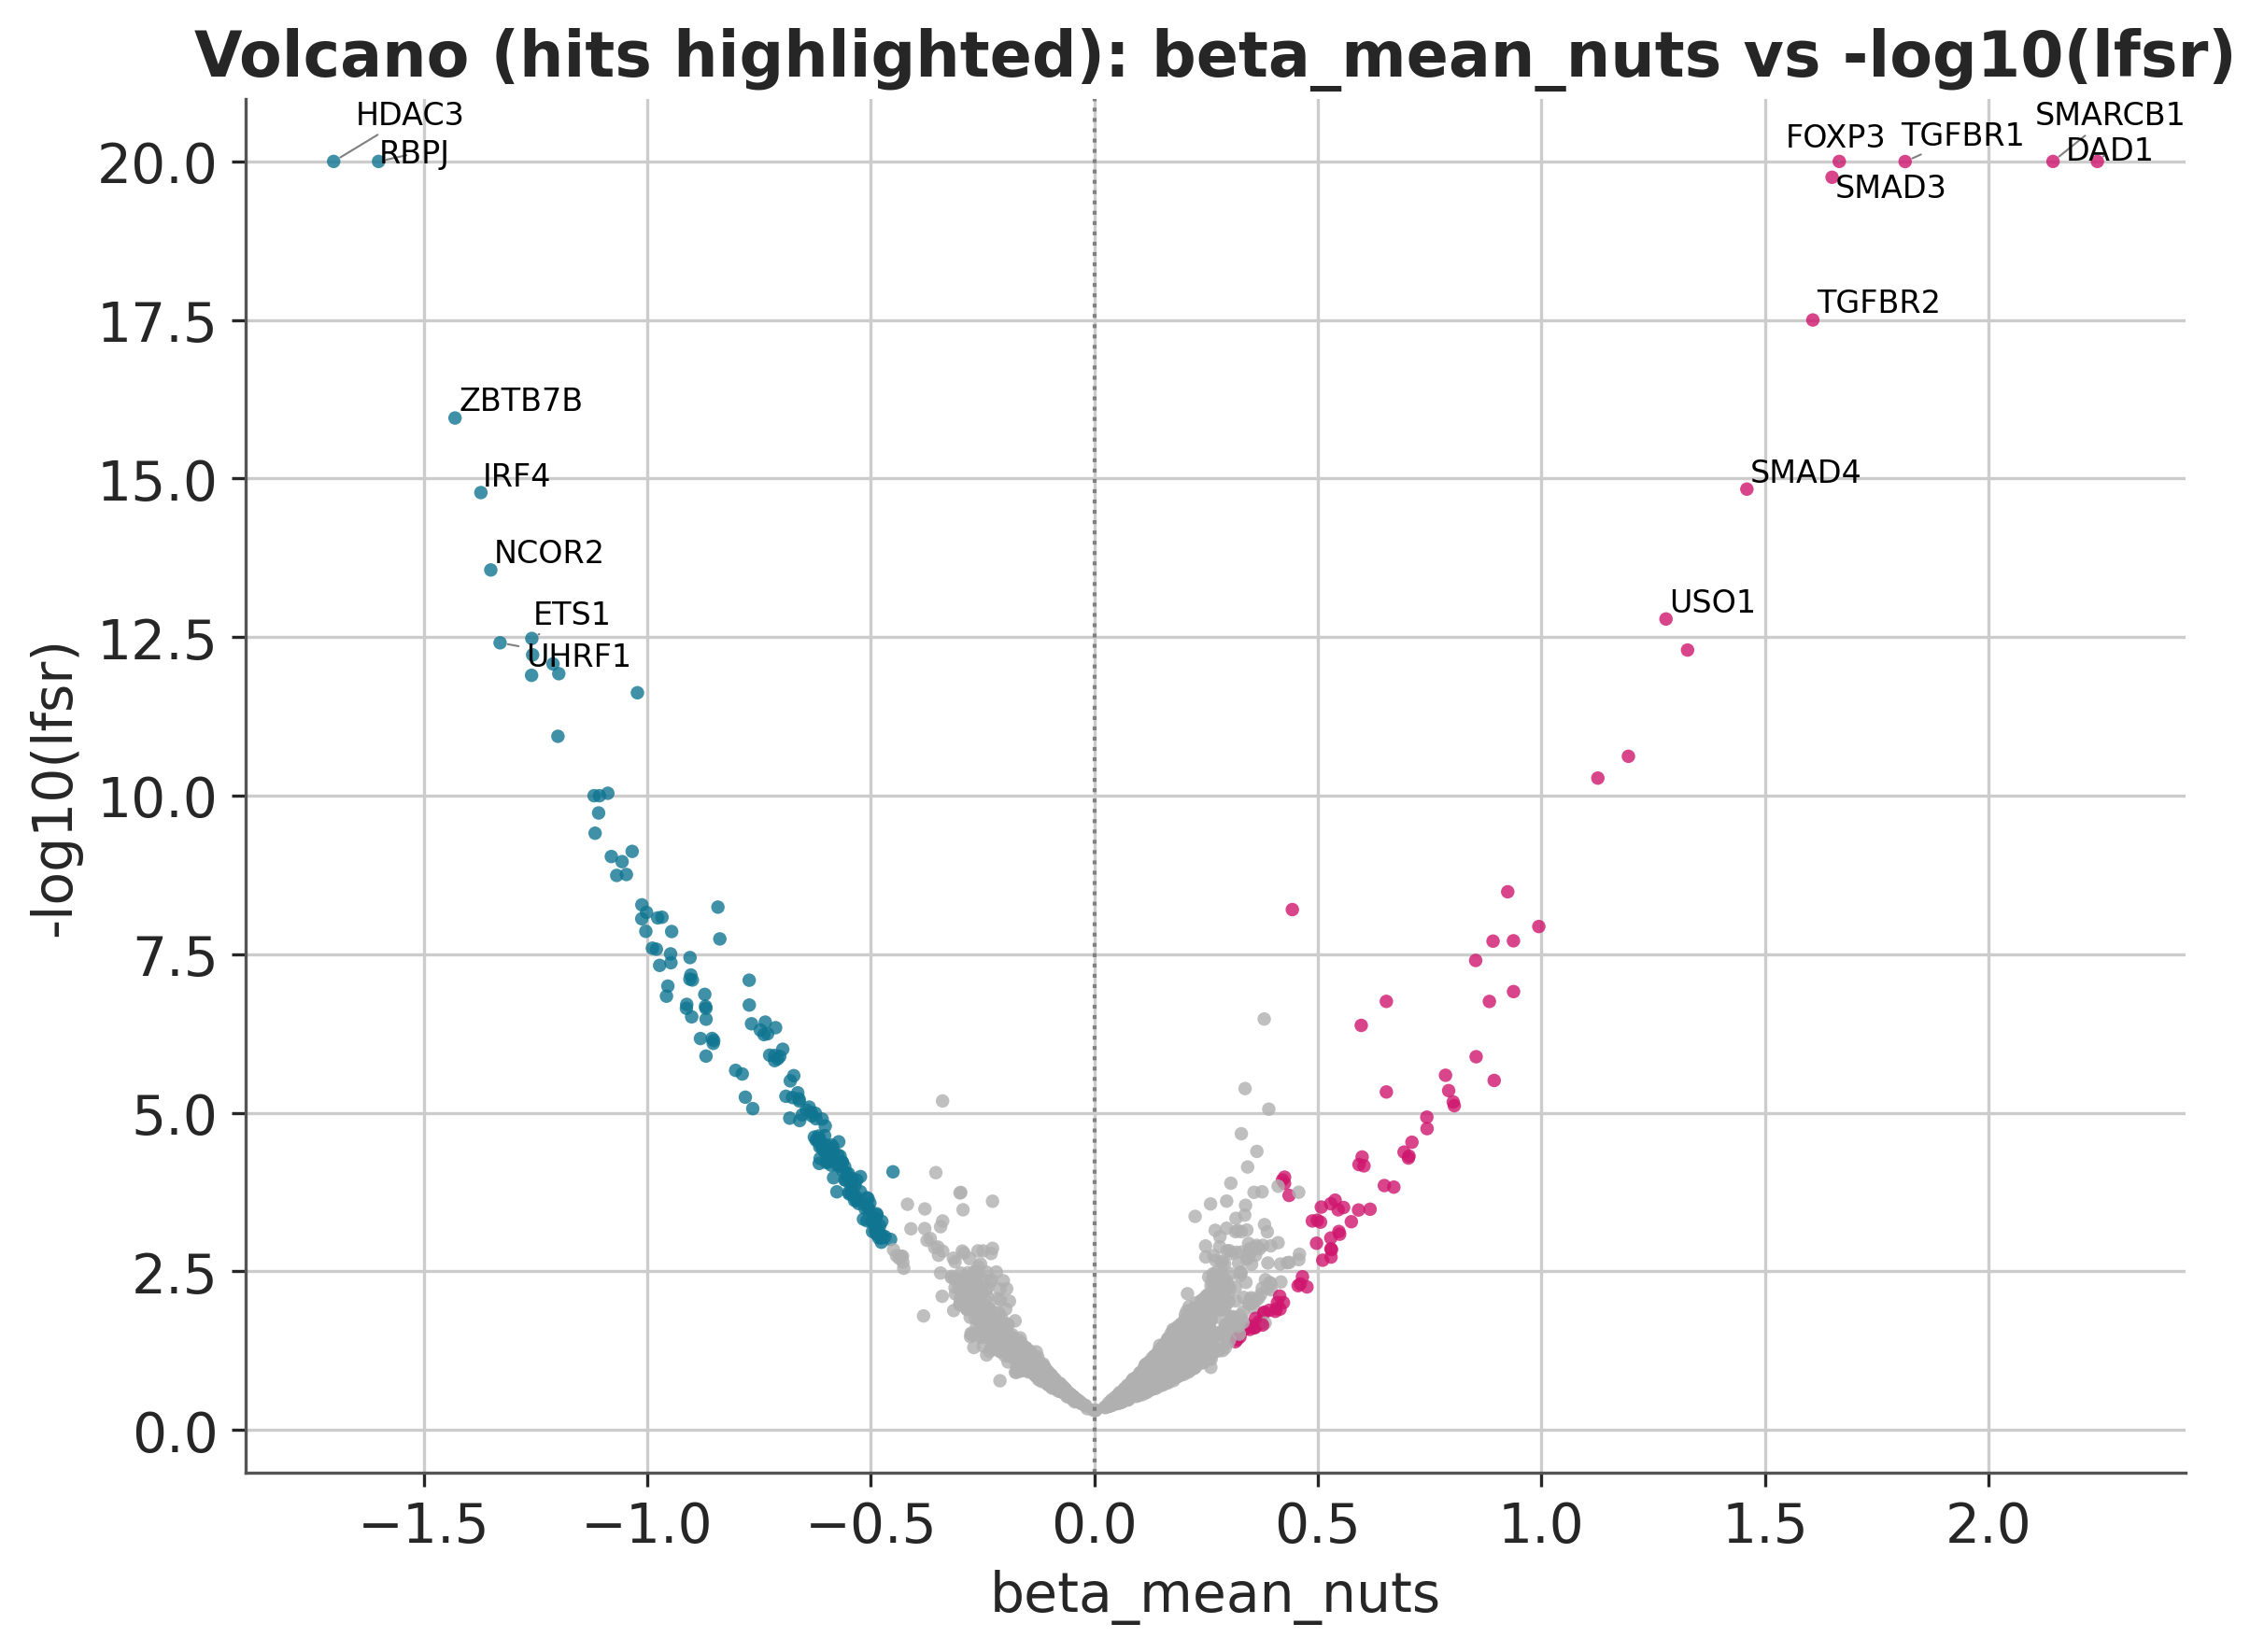

Hits-highlighted volcano created from: outputs/tables/bayes_gene_summary_nb_multi_nuts_normal_approx.csv
Columns used: beta=beta_mean_nuts, lfsr=lfsr_norm
Saved figure to: outputs/figures/volcano_beta_mean_vs_neglog10_lfsr_hits_colored_nonhits_gray_normal_approx.png
Points plotted: 3000


In [53]:
# Volcano plot (hits highlighted): beta_mean vs -log10(lfsr), non-hits gray
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Preferred and fallback tables
normal_csv = "outputs/tables/bayes_gene_summary_nb_multi_nuts_normal_approx.csv"
fallback_csv = "outputs/tables/bayes_gene_summary_nb_multi_nuts_with_probs.csv"

# Load data with fallback
if os.path.exists(normal_csv):
    df = pd.read_csv(normal_csv)
    used = normal_csv
else:
    df = pd.read_csv(fallback_csv)
    used = fallback_csv

# Resolve columns
beta_cols = [c for c in ["beta_mean_nuts", "beta_mean", "beta_hat", "beta"] if c in df.columns]
if not beta_cols:
    beta_cols = [c for c in df.columns if ("beta" in c.lower() and "mean" in c.lower())]
if not beta_cols:
    raise ValueError("Could not find a beta mean column. Looked for beta_mean_nuts, beta_mean, beta_hat, beta.")

beta_col = beta_cols[0]

lfsr_cols = [c for c in ["lfsr_norm", "lfsr_nuts", "lfsr"] if c in df.columns]
if not lfsr_cols:
    psp_cols = [c for c in df.columns if c.lower().startswith("psp") or c.lower().startswith("p_sign")]
    if psp_cols:
        p = df[psp_cols[0]].clip(0, 1)
        df["lfsr_norm"] = np.minimum(p, 1 - p)
        lfsr_cols = ["lfsr_norm"]
if not lfsr_cols:
    raise ValueError("Could not find or derive an lfsr column. Expected lfsr_norm, lfsr_nuts, or lfsr.")

lfsr_col = lfsr_cols[0]

# Determine hit flag
hit_cols = [c for c in ["is_hit", "hit", "hit_flag", "hit_gene", "significant", "is_significant"] if c in df.columns]
if hit_cols:
    hit_flag = df[hit_cols[0]].astype(bool)
else:
    # default: lfsr <= 0.1
    hit_flag = (df[lfsr_col] <= 0.1)

# Prepare data
plot_df = df[[beta_col, lfsr_col]].copy()
plot_df = plot_df.replace([np.inf, -np.inf], np.nan).dropna()
plot_df["neglog10_lfsr"] = -np.log10(np.clip(plot_df[lfsr_col], 1e-300, 1.0)+1e-20)
# align hit flag to plot_df index
plot_df = plot_df.join(hit_flag.rename("is_hit"), how="left")
plot_df["is_hit"].fillna(False, inplace=True)

# Colors: non-hits gray; hits red if beta>=0 else blue
plot_df["color"] = "#B0B0B0"  # gray for non-hits
mask_hit = plot_df["is_hit"].astype(bool)
plot_df.loc[mask_hit & (plot_df[beta_col] >= 0), "color"] = "C9"
plot_df.loc[mask_hit & (plot_df[beta_col] < 0), "color"] = "C0"

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(plot_df[beta_col], plot_df["neglog10_lfsr"], c=plot_df["color"], s=12, edgecolors="none", alpha=0.8)
plt.axvline(0, color="gray", linestyle=":", linewidth=1)
plt.xlabel(beta_col)
plt.ylabel("-log10(lfsr)")
plt.title("Volcano (hits highlighted): {} vs -log10(lfsr)".format(beta_col))
plt.tight_layout()

from adjustText import adjust_text
# Optional labels for top points
if label_col is not None and len(plot_df) > 0:
    top_k = min(15, len(plot_df))
    temp = plot_df.copy()
    temp = temp.join(df[label_col], how="left")
    top = temp.nlargest(top_k, "neglog10_lfsr")
    texts = []
    for _, row in top.iterrows():
        texts.append(plt.text(row[beta_col], row["neglog10_lfsr"], row[label_col], 
                              fontsize=8, color="black"))
    adjust_text(texts, arrowprops=dict(arrowstyle='-', color='gray', lw=0.5))


# Save figure
out_fig = "outputs/figures/volcano_beta_mean_vs_neglog10_lfsr_hits_colored_nonhits_gray_normal_approx.png" if used == normal_csv else "outputs/figures/volcano_beta_mean_vs_neglog10_lfsr_hits_colored_nonhits_gray.png"
os.makedirs(os.path.dirname(out_fig), exist_ok=True)
plt.savefig(out_fig, dpi=200)
plt.show()

print(f"Hits-highlighted volcano created from: {used}")
print(f"Columns used: beta={beta_col}, lfsr={lfsr_col}")
print(f"Saved figure to: {out_fig}")
print(f"Points plotted: {len(plot_df)}")